In [1]:
"""
注意事項(關於ver2)： 
一、神經網路架構：
    3層CNN(卷積神經網絡) + 2層Linear

二、狀態變數(一共37個)： 
    收盤價MA5, 收盤價MA10, 收盤價MA20, 收盤價MA60, 收盤價MA120, 收盤價MA240
    成交股數MA5, 成交股數MA10, 成交股數MA20, 成交股數MA60, 成交股數MA120, 成交股數MA240
    成交金額MA5, 成交金額MA10, 成交金額MA20, 成交金額MA60, 成交金額MA120, 成交金額MA240
    成交股數.1
    開盤價.1
    最高價.1
    最低價.1
    收盤價.1
    漲跌價差.1
    月份(one-hot，一到十二月共十二個變數)
    當前資產部位

三、reward公式：
    reward(t) = ln(Wt / Wt-1)
    
    Action  Wt                            Wt-1
    -----------------------------------------------------------------
    wait    t期agent持有的現金             t-1期agent持有的現金
    
    buy     t期收盤價 * agent持有的股數    t-1期agent持有的現金
    
    hold    t期收盤價 * agent持有的股數    t-1期收盤價 * agent持有的股數
    
    sell    t期agent持有的現金             t-n期買價 * agent持有的股數
            (t期開盤價 * agent持有的股數 
            * (1 - 交易成本比率))
            
四、調參成效的指標
    1. 訓練集最後100個episode的平均報酬率
    2. 驗證集的平均報酬率
    
五、嘗試調整方向
    1. 交易價格統一用t-1期收盤價
    2. 

"""
# 輸入相關的函式庫
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import statistics
import csv
import matplotlib.pyplot as plt
import math
from torch.autograd import Variable
from copy import deepcopy
import pandas as pd

In [2]:
# 可調整的超參數
TARGET_REPLACE_ITER = 5 # x；target network更新的頻率(每訓練幾次更新一次)
BATCH_SIZE_ACCOUNT_FOR_MEMORY_CAPACITY = 0.08 # 訓練抽取的批量大小為記憶體大小的多少比例(0到1之間)

LR = 0.003 # learning rate (學習率，越大代表訓練速度將會越快，但太大可能會導致模型難以收斂)
GAMMA = 0.95 # discount rate (折現率，越接近1代表DQN越重視未來的經驗)

EPSILON_MIN = 0.01 # 隨機選取行動的機率的最小值
EPSILON_DECAY = 0.995 # 隨機選取行動的機率在每次訓練一次後衰退所剩餘的比例 (該值必須介於0到1之間)

# 第一層的節點數

# 以下超參數不建議在現階段調整
EPISODES = 1000 # 訓練過程中的疊代次數(一共要玩幾輪股市交易)

EPSILON = 1.0  # 隨機(而非依據模型結果)選取行動的機率的起始值

'''
台灣50
'''
TRAIN_START_DAY = '2014/1/2' # 訓練集起始的日期
TRAIN_END_DAY = '2015/12/31' # 訓練集結束的日期

VALIDATION_START_DAY = '2016/1/4' # 驗證集起始的日期
VALIDATION_END_DAY = '2016/3/31' # 驗證集結束的日期

TEST_START_DAY = '2016/4/1' # 驗證集起始的日期
TEST_END_DAY = '2016/6/30' # 驗證集結束的日期

'''
燦坤
'''
# TRAIN_START_DAY = '2015/1/5' # 訓練集起始的日期
# TRAIN_END_DAY = '2016/12/30' # 訓練集結束的日期

# VALIDATION_START_DAY = '2017/1/3' # 驗證集起始的日期
# VALIDATION_END_DAY =  '2017/3/31'# 驗證集結束的日期

# TEST_START_DAY = '2017/4/5' # 驗證集起始的日期
# TEST_END_DAY = '2017/6/30' # 驗證集結束的日期
'''
東元
'''
# TRAIN_START_DAY = '2014/1/2' # 訓練集起始的日期
# TRAIN_END_DAY = '2015/12/31' # 訓練集結束的日期

# VALIDATION_START_DAY = '2016/1/4' # 驗證集起始的日期
# VALIDATION_END_DAY =  '2016/3/31'# 驗證集結束的日期

# TEST_START_DAY = '2016/4/1' # 驗證集起始的日期
# TEST_END_DAY = '2016/6/30' # 驗證集結束的日期

# 以下超參數目前在這邊設定並不會發揮作用，可以忽略
MEMORY_CAPACITY = 2000 # memory(記憶體)的大小
BATCH_SIZE = 20 # b；每次訓練時從memory中選取要訓練的資料的批量大小
#ENOUGH_MEMORY_TO_TRAIN = 200 # 當memory超過多少筆資料才開始訓練模型
#TRAIN_INTERVAL = 5 # k；每增加多少筆經驗(每過幾天)會再次訓練模型

'''
正常版
'''

# 以下的超參數必須根據不同的資料集(csv檔)做修改
YOUR_CSVFILE_PATH = "D:/專案/資料集/twse0050_ver10.csv" # 路徑請自己改
N_STATES = 37 # state size (= [收盤價MA5, 收盤價MA10, ... ,當前資產部位]，一共37個狀態變數)
STATE_VARIABLE_DISCRETE_START_INDEX = 33 # 資料集中離散(類別)型別的狀態變數開始的欄位的「索引(從0開始算)_」(一月) 

# 以下的超參數是目前希望特定的欄位在資料集中所在的位置，能不改就不要改
N_COLUMNS = 46 
    # 資料集一共的欄位數(前九個希望固定為「日期, 成交股數, 成交金額, 成交筆數, 開盤價, 最高價, 最低價, 收盤價, 漲跌價差」)
OPENING_PRICE_INDEX = 4 # 資料集中「開盤價」欄位的索引
CLOSING_PRICE_INDEX = 7 # 資料集中「收盤價」欄位的索引
STATE_VARIABLE_START_INDEX = 9 # 資料集中狀態變數開始的欄位的「索引」(從0開始算)(收盤價MA5)
STATE_VARIABLE_CONTINUOUS_END_INDEX = STATE_VARIABLE_DISCRETE_START_INDEX - 1 
    # 資料集中連續型別的狀態變數結束的欄位的索引(漲跌價差.1) (目前希望離散型別的狀態變數接在類別型別的狀態變數之後)
CURRENT_POSITION_INDEX = 45 # 資料集中「當前資產部位」欄位的索引 (目前希望是位在資料集中最後一個欄位)

# 以下的超參數並非是調參的重點，能不改就不要改
N_ACTIONS = 2 # action size (= [0, 1])
TRANSACTION_COST_RATE = 0.001425 # 參考實際的手續費率
'''
簡易版
'''
# # 以下的超參數必須根據不同的資料集(csv檔)做修改
# YOUR_CSVFILE_PATH = "D:/專案/資料集/twse0050_ver11(新增成對交易欄位-變數簡易版).csv" # 路徑請自己改
# N_STATES = 8 # state size (= [收盤價MA5, 收盤價MA10, ... ,當前資產部位]，一共37個狀態變數)
# STATE_VARIABLE_DISCRETE_START_INDEX = 17 # 資料集中離散(類別)型別的狀態變數開始的欄位的「索引(從0開始算)_」(一月) 

# # 以下的超參數是目前希望特定的欄位在資料集中所在的位置，能不改就不要改
# N_COLUMNS = 18 
#     # 資料集一共的欄位數(前九個希望固定為「日期, 成交股數, 成交金額, 成交筆數, 開盤價, 最高價, 最低價, 收盤價, 漲跌價差」)
# OPENING_PRICE_INDEX = 4 # 資料集中「開盤價」欄位的索引
# CLOSING_PRICE_INDEX = 7 # 資料集中「收盤價」欄位的索引
# STATE_VARIABLE_START_INDEX = 10 # 資料集中狀態變數開始的欄位的「索引」(從0開始算)(收盤價MA5)
# STATE_VARIABLE_CONTINUOUS_END_INDEX = STATE_VARIABLE_DISCRETE_START_INDEX - 1 
#     # 資料集中連續型別的狀態變數結束的欄位的索引(漲跌價差.1) (目前希望離散型別的狀態變數接在類別型別的狀態變數之後)
# CURRENT_POSITION_INDEX = 17 # 資料集中「當前資產部位」欄位的索引 (目前希望是位在資料集中最後一個欄位)

# # 以下的超參數並非是調參的重點，能不改就不要改
# N_ACTIONS = 2 # action size (= [0, 1])
# TRANSACTION_COST_RATE = 0.001425 # 參考實際的手續費率

'''
燦坤 變數完整版
'''
# # 以下的超參數必須根據不同的資料集(csv檔)做修改
# YOUR_CSVFILE_PATH = "D:/專案/資料集/燦坤2430_ver2.csv" # 路徑請自己改
# N_STATES = 38 # state size (= [收盤價MA5, 收盤價MA10, ... ,當前資產部位]，一共37個狀態變數)
# STATE_VARIABLE_DISCRETE_START_INDEX = 35 # 資料集中離散(類別)型別的狀態變數開始的欄位的「索引(從0開始算)_」(一月) 

# # 以下的超參數是目前希望特定的欄位在資料集中所在的位置，能不改就不要改
# N_COLUMNS = 48 
#     # 資料集一共的欄位數(前九個希望固定為「日期, 成交股數, 成交金額, 成交筆數, 開盤價, 最高價, 最低價, 收盤價, 漲跌價差」)
# OPENING_PRICE_INDEX = 4 # 資料集中「開盤價」欄位的索引
# CLOSING_PRICE_INDEX = 7 # 資料集中「收盤價」欄位的索引
# STATE_VARIABLE_START_INDEX = 10 # 資料集中狀態變數開始的欄位的「索引」(從0開始算)(收盤價MA5)
# STATE_VARIABLE_CONTINUOUS_END_INDEX = STATE_VARIABLE_DISCRETE_START_INDEX - 1 
#     # 資料集中連續型別的狀態變數結束的欄位的索引(漲跌價差.1) (目前希望離散型別的狀態變數接在類別型別的狀態變數之後)
# CURRENT_POSITION_INDEX = 47 # 資料集中「當前資產部位」欄位的索引 (目前希望是位在資料集中最後一個欄位)

# # 以下的超參數並非是調參的重點，能不改就不要改
# N_ACTIONS = 2 # action size (= [0, 1])
# TRANSACTION_COST_RATE = 0.001425 # 參考實際的手續費率

'''
東元 變數完整版
'''
# # 以下的超參數必須根據不同的資料集(csv檔)做修改
# YOUR_CSVFILE_PATH = "D:/專案/資料集/東元1504_ver1.csv" # 路徑請自己改
# N_STATES = 38 # state size (= [收盤價MA5, 收盤價MA10, ... ,當前資產部位]，一共37個狀態變數)
# STATE_VARIABLE_DISCRETE_START_INDEX = 35 # 資料集中離散(類別)型別的狀態變數開始的欄位的「索引(從0開始算)_」(一月) 

# # 以下的超參數是目前希望特定的欄位在資料集中所在的位置，能不改就不要改
# N_COLUMNS = 48 
#     # 資料集一共的欄位數(前九個希望固定為「日期, 成交股數, 成交金額, 成交筆數, 開盤價, 最高價, 最低價, 收盤價, 漲跌價差」)
# OPENING_PRICE_INDEX = 4 # 資料集中「開盤價」欄位的索引
# CLOSING_PRICE_INDEX = 7 # 資料集中「收盤價」欄位的索引
# STATE_VARIABLE_START_INDEX = 10 # 資料集中狀態變數開始的欄位的「索引」(從0開始算)(收盤價MA5)
# STATE_VARIABLE_CONTINUOUS_END_INDEX = STATE_VARIABLE_DISCRETE_START_INDEX - 1 
#     # 資料集中連續型別的狀態變數結束的欄位的索引(漲跌價差.1) (目前希望離散型別的狀態變數接在類別型別的狀態變數之後)
# CURRENT_POSITION_INDEX = 47 # 資料集中「當前資產部位」欄位的索引 (目前希望是位在資料集中最後一個欄位)

# # 以下的超參數並非是調參的重點，能不改就不要改
# N_ACTIONS = 2 # action size (= [0, 1])
# TRANSACTION_COST_RATE = 0.001425 # 參考實際的手續費率

'\n東元 變數完整版\n'

In [3]:
class Net(nn.Module):
    '''
        建立現實網路(Target Net)及估計網路(Eval Net)
    '''
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 10)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization  
#         self.fc2 = nn.Linear(10, 10)
#         self.fc2.weight.data.normal_(0, 0.1)   # initialization 
        self.out = nn.Linear(10, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
        actions_value = self.out(x)
        return actions_value
    
    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
        actions_value = self.forward(x)
        print(actions_value.detach().numpy())
        action = np.argmax(actions_value.detach().numpy())     # return the argmax
        
        return action
    
        '''
        input torch.Size([147, 1, 1, 37])
        
        conv1 torch.Size([147, 16, 1, 19])
        conv2 torch.Size([147, 32, 1, 10])
        conv3 torch.Size([147, 32, 1, 5])
        
        Flat  torch.Size([147, 128])
        fc4   torch.Size([147, 64])
        fc5   torch.Size([147, 2])
        '''

In [4]:
class DQN(object):
    '''
        具體DQN功能
    '''
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        # 載入上次最好的參數作為起點
#         start_param = torch.load('train_last_best_param_as_start.pkl')
# #         print(start_param)
#         self.eval_net.load_state_dict(start_param)
#         self.target_net.load_state_dict(start_param)
        
        self.learn_step_counter = 0 # 用於target更新計時
        self.memory_counter = 0 # 記憶庫計數
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2)) # 初始化記憶庫
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR) # torch的優化器
        self.loss_func = nn.MSELoss() # 誤差公式(MSE)
        
        self.epsilon = EPSILON  # exploration rate
        self.epsilon_min = EPSILON_MIN
        self.epsilon_decay = EPSILON_DECAY

    def choose_action(self, x,hi=False):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        
        # 這裡只輸入一個 sample
        if np.random.uniform() > self.epsilon: # 選最優動作
            actions_value = self.eval_net.forward(x)
            if hi:
                print(actions_value)
            #action = torch.max(actions_value, 1)[1].data.numpy()[0, 0] # return the argmax # 這樣action永遠會選到0
            action = np.argmax(actions_value.detach().numpy()) 
        else:   # 隨機選動作
            action = np.random.randint(0, N_ACTIONS)
        return action
    
        

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # 如果記憶庫滿了，就覆蓋老數據
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target net 参數更新
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # 抽取記憶庫中的批數據
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])
        
        ### double DQN實作 ###
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)

        # 取得「Q估計(q_eval)」估計出來的動作
        q_eval_test= self.eval_net(b_s)
        Q1_argmax = np.argmax(q_eval_test.data.numpy(),axis = 1)

        # 用「Q估計(q_eval)」估計出來的動作，取得「Q現實(q_next，和target network，即老神經網路相關)」中的Q值，即q_target
        q_next = self.target_net(b_s_) 
        
        q_next_numpy = q_next.data.numpy()
        q_update = np.zeros((BATCH_SIZE,1))

        for i in range(BATCH_SIZE):
            q_update[i] = q_next_numpy[i , Q1_argmax[i]]

        q_update = GAMMA * q_update
        q_update = torch.FloatTensor(q_update)
        variable11 = Variable(q_update)
        q_target = b_r + variable11
        
        loss = self.loss_func(q_eval, q_target)

        self.loss = loss
        
        # 計算, 更新 eval net
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # 讓隨機選取行動的機率隨著遊玩次數增加而遞減
        if self.epsilon > self.epsilon_min: 
            self.epsilon *= self.epsilon_decay

    def copy_params(self, a):
        self.eval_net.load_state_dict(a)

In [5]:
# --------------- 主程式 ----------------
            
if __name__ == "__main__": 
    
    # --------------- 資料前置作業 ----------------
    
    # if __name__ == "__main__ 目的在於當該檔案被別的py檔引用時，不會執行以下的程式碼 (別的py檔可以引用上面的class或是def)

    # 載入股市資料集
    csvfile = open(YOUR_CSVFILE_PATH, newline='', encoding='utf-8') # encoding有時可能為utf-8，要注意！
    csvfile_rows = list(csv.reader(csvfile))

    # 資料型態轉換(把大多數的變數的資料型態從str轉成int或是float)
    for i in csvfile_rows[1:]:
        for j in range(1, N_COLUMNS):
            if i[j] != '' and j in [1,2,3] or j in range(STATE_VARIABLE_DISCRETE_START_INDEX, N_COLUMNS):
                i[j] = int(i[j])
            elif i[j] != '':
                i[j] = float(i[j])
            else:
                i[j] = 'NA' # 把空值設成'NA'

    # 取得訓練集
    csvfile_rows_train_start_day = TRAIN_START_DAY
    csvfile_rows_train_start_day_index = -1
    
    csvfile_rows_train_end_day = TRAIN_END_DAY
    csvfile_rows_train_end_day_index = -1
    
    for i in range(0, len(csvfile_rows)):
        if csvfile_rows[i][0] == csvfile_rows_train_start_day:
            csvfile_rows_train_start_day_index = i
        if csvfile_rows[i][0] == csvfile_rows_train_end_day:
            csvfile_rows_train_end_day_index = i
    
    csvfile_rows_train = csvfile_rows[csvfile_rows_train_start_day_index : csvfile_rows_train_end_day_index + 1]
    # csvfile_rows_train_end_day_index要加1的原因是因為[n:m]是從n取到m-1

    # 對訓練集的資料做特徵縮放(feature scaling)
    csvfile_rows_train = np.transpose(csvfile_rows_train)
    csvfile_rows_train = np.ndarray.tolist(csvfile_rows_train)
    for i in csvfile_rows_train[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1]:
        for j in range(0, len(i)):
            i[j] = float(i[j])
    train_mean_list = []
    train_std_list = []
    for i in csvfile_rows_train[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1]:
        status_variable_mean = statistics.mean(i)
        status_variable_stdev = statistics.stdev(i)
        train_mean_list.append(status_variable_mean)
        train_std_list.append(status_variable_stdev)
        for j in range(0, len(i)):
            i[j] = (i[j] - status_variable_mean) / status_variable_stdev
    
    #print(csvfile_rows_train[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1])
        # 查看訓練集是否有做到特徵縮放
    csvfile_rows_train = np.transpose(csvfile_rows_train)
    csvfile_rows_train = np.ndarray.tolist(csvfile_rows_train)
    for i in csvfile_rows_train:
        for j in range(1, N_COLUMNS):
            if i[j] != '' and j in [1,2,3] or j in range(STATE_VARIABLE_DISCRETE_START_INDEX, N_COLUMNS):
                i[j] = int(i[j])
            elif i[j] != '':
                i[j] = float(i[j])
                
    #print(csvfile_rows_train[1:4]) # 查看訓練集是否有在「對的欄位」(連續狀態變數的欄位)做到特徵縮放

    ### 將類別變數轉成獨熱編碼的形式 ###
    # 待補

    csvfile.close()
    
    # 記憶體的大小以訓練集的長度為基礎，會視獎勵函數的設計微調(目前每個episode是從訓練集的第二天跑到訓練集的最後一天，因此要減掉一)
    MEMORY_CAPACITY = len(csvfile_rows_train) - 1 # 以目前訓練集所選的起始、結束日期，並結合獎勵函數來看，記憶體的大小應為735
    
    # 目前暫定每次訓練時從記憶體中選取要訓練的資料的批量大小為記憶體大小的20%
    BATCH_SIZE = round(MEMORY_CAPACITY * BATCH_SIZE_ACCOUNT_FOR_MEMORY_CAPACITY)
    #print(BATCH_SIZE) # 147
    
    dqn = DQN() # 定義DQN系統

    # 建立紀錄performance、transaction times、total reward和loss的列表(list),之後畫圖會用到
    performance_list = []
    transaction_times_list = []
    reward_list = []
    loss_list = []
    
    # 建立一個字典去存神經網路參數(以實體報酬率作為key，其對應的神經網路參數為value)
    param_dict = {}
    param_list = []
    
    episode_start_day_index = 1 # 挑選訓練集第二個交易日為episode開始的日期(因為會用到第一個交易日的狀態變數資料，所以要從第二天開始)
    episode_start_day = csvfile_rows_train[episode_start_day_index][0]

    episode_end_day_index = len(csvfile_rows_train) - 1 # 挑選訓練集倒數第一個交易日為episode結束的日期
    episode_end_day = csvfile_rows_train[episode_end_day_index][0]
    
    training_set_buy_and_hold_return = ((csvfile_rows_train[len(csvfile_rows_train) - 1][OPENING_PRICE_INDEX]
               - csvfile_rows_train[0][OPENING_PRICE_INDEX]) / csvfile_rows_train[0][OPENING_PRICE_INDEX])
    print("在訓練集中，使用B&H的報酬率為：", training_set_buy_and_hold_return)
         
    print("--------------------------以下開始訓練模型-------------------------")

    for i_episode in range(EPISODES):

        # 重新一個EPISODE時把所有訓練資料中的資產持有狀態全部設為0 (開始投資之前不會有資料的資產持有狀態為1，因為根本還沒有開始買股票)
        for i in csvfile_rows_train:
            i[CURRENT_POSITION_INDEX] = 0

        state = csvfile_rows_train[episode_start_day_index - 1][STATE_VARIABLE_START_INDEX:] # 根據日期取得狀態變數
        np.asarray(state, dtype = float)
        state = np.reshape(state, [1, N_STATES]) # 為了讓狀態可以餵進神經網路所做的維度調整

        initial_principal = 100000 # 本金
        cash_hold = initial_principal # agent目前「實際」持有的現金
        transaction_cost_rate = 0.001425 # 交易成本(手續費)比率
        number_of_shares_held = 0 # 持有股數(每一次EPISODE開始前都要歸零)

        done = False # 是否結束該EPISODE(結束條件為在持有股票的狀態下選擇賣掉股票的行動)
        reward = 0 # 獎勵(訓練模型用)
        performance = 0 # 該EPISODE「實際」的投資報酬率

        transaction_times = 0 # 該EPISODE發生的交易次數(買和賣皆算進行一次交易)
        total_reward = 0 #以獎勵總值表示performance

        dqn.memory_counter = 0
        
        buy_price = 0 # 買入股票的價格
        
        maxSellReward = 0 # 買入後的最高賣出報酬
        
        profit = 0 # 賺到的錢，不再拿去投資

        for day in range(episode_start_day_index, episode_end_day_index + 1):

            # 選擇行動
            hi=False
            if i_episode == 999:
                hi=True
            action = dqn.choose_action(state,hi)
#             print(state[0])

            # 當EPISODE進行到倒數第一天時就要強制結束該EPISODE，因為後面沒資料了
            if day == (episode_end_day_index):
                done = True
                if (csvfile_rows_train[day - 1][CURRENT_POSITION_INDEX] == 0): 
                    # 如果t-1期的agent之前持有的是現金，則繼續持有現金(wait)
                    action = 0
                    
                    # 繼續持有現金的獎勵必定為0 (t期agent持有的現金 = t-1期agen持有的現金)
                    reward = 0
                    total_reward += reward
                    
                else:
                    # 如果agent之前持有的是股票，則強制賣出股票(sell)
                    action = 1 
                    
                    # 根據公式計算出agent在賣出股票後將會持有的現金
                    cash_hold = (number_of_shares_held * csvfile_rows_train[day][CLOSING_PRICE_INDEX] 
                                 * (1 - transaction_cost_rate))

                    # 計算賣出股票的獎勵
                    w_t = cash_hold # t期agent持有的現金
#                     w_t_prev =  csvfile_rows_train[day][CLOSING_PRICE_INDEX] * number_of_shares_held 
                    w_t_prev =  buy_price * number_of_shares_held 
                    # t-1期收盤價 * agent持有的股數 
                    reward = math.log(w_t / w_t_prev)
#                     reward = math.log(w_t / 100000)            
                    total_reward += reward

                    # 每賣出一次股票，該EPISODE的交易次數就增加一次
                    transaction_times += 1 
                    if(i_episode == 999):
                        print(day , "最後一期賣")

            # 根據行動計算獎勵
            if csvfile_rows_train[day - 1][CURRENT_POSITION_INDEX] == 0 and done == False:

                if action == 1: # 如果t-1期的當前資產部位為持有現金(current position = 0)，且行動為1(action = 1)，則買入股票(buy)
                    
                    # 買入股票的價格為t期的開盤價
                    #buy_price = csvfile_rows_train[day][OPENING_PRICE_INDEX] 
                    buy_price = csvfile_rows_train[day][CLOSING_PRICE_INDEX]
                    
                    
                    # 根據公式計算出agent在買入股票後將會持有的股數
                    number_of_shares_held = cash_hold  / (buy_price * (1 + transaction_cost_rate))
                    

                    # 計算買入股票的獎勵
                    w_t = csvfile_rows_train[day+1][CLOSING_PRICE_INDEX] * number_of_shares_held # t期收盤價 * agent持有的股數
                    w_t_prev = cash_hold # t-1期agen持有的現金
#                     reward = math.log(w_t/w_t_prev)
                    reward = 0
#                     reward = math.log(w_t / 100000)
                    total_reward += reward
                    
                    # 買入股票後，t期的「資產當前部位」將設為1
                    csvfile_rows_train[day][CURRENT_POSITION_INDEX] = 1
                    
                    # 由於將所有的現金拿去買股票，所以之後agent持有的現金為0
                    cash_hold = 0 
                    
                    # 每買入一次股票，該EPISODE的交易次數就增加一次
                    transaction_times += 1
                    if(i_episode == 999):
                        print(day , "買")
                    
                    
                elif action == 0: # 如果當前資產部位為持有現金(current position = 0)，且行動為1(action = 0)，則繼續持有現金(wait)
                    
                    # 繼續持有現金的獎勵必定為0 (t期agent持有的現金 = t-1期agen持有的現金)
                    # Wait: Min (-Buy Reward, 0)
                    buy_price_cur = csvfile_rows_train[day][CLOSING_PRICE_INDEX]
                    number_of_shares_held_cur = cash_hold  / (buy_price_cur * (1 + transaction_cost_rate))
                    buy_w_t = csvfile_rows_train[day+1][CLOSING_PRICE_INDEX] * number_of_shares_held_cur # t期收盤價 * agent持有的股數
                    buy_w_t_prev = cash_hold # t-1期agen持有的現金
                    buy_reward = math.log(buy_w_t / buy_w_t_prev)
#                     reward = min(-buy_reward,0)
                    reward = 0
#                     reward = math.log(cash_hold / 100000)
                    total_reward += reward

            elif csvfile_rows_train[day - 1][CURRENT_POSITION_INDEX] == 1 and done == False:

                if action == 1: # 如果t-1期的當前資產部位為持有股票(current position = 1)，且行動為1(action = 1)，則賣出股票(sell)
                    
   
                    # 根據公式計算出agent在賣出股票後將會持有的現金
                    cash_hold = (number_of_shares_held * csvfile_rows_train[day][CLOSING_PRICE_INDEX] 
                                 * (1 - transaction_cost_rate))
                    # 計算賣出股票的獎勵
                    w_t = cash_hold # t期agent持有的現金
#                     w_t_prev = csvfile_rows_train[day-1][CLOSING_PRICE_INDEX] * number_of_shares_held # t-n期買價 * agent持有的股數
                    w_t_prev = buy_price * number_of_shares_held
                    reward = math.log(w_t / w_t_prev) 
#                     reward = math.log(w_t / 100000)
                    total_reward += reward 
                    
                    # 每賣出一次股票，該EPISODE的交易次數就增加一次
                    transaction_times += 1 
                    if(i_episode == 999):
                        print(day , "賣")
                    #number_of_shares_held = 0
                    
                    # 若賺的錢超過本金，只拿本金再投資
#                     if cash_hold > initial_principal:
#                         profit += cash_hold - initial_principal
#                         cash_hold = initial_principal
                 
                elif action == 0: # 如果當前資產部位為持有股票(current position = 1)，且行動為0(action = 0)，則繼續持有股票(hold)
                    cash_hold_cur = (number_of_shares_held * csvfile_rows_train[day][CLOSING_PRICE_INDEX] 
                                 * (1 - transaction_cost_rate))
                    sell_w_t = cash_hold_cur # t期agent持有的現金
                    sell_w_t_prev = buy_price * number_of_shares_held
                    sell_reward = math.log(sell_w_t / sell_w_t_prev)
                    if sell_reward > maxSellReward:
                        maxSellReward = sell_reward
                        
                    
                    # 計算繼續持有股票的獎勵
                    w_t = csvfile_rows_train[day+1][CLOSING_PRICE_INDEX] * number_of_shares_held # t期收盤價 * agent持有的股數
#                     w_t_prev = csvfile_rows_train[day][CLOSING_PRICE_INDEX] * number_of_shares_held # t-1期收盤價 * agent持有的股數
                    w_t_prev = buy_price * number_of_shares_held
                    hold_reward = math.log(w_t / w_t_prev)
#                     reward = math.log(w_t / 100000)
#                     reward = 0
#                     if hold_reward > maxSellReward:
#                         reward = hold_reward
#                     else:
#                         reward = 0
#                     reward = hold_reward
                    reward = 0
                    total_reward += reward
                    
                    
                    # 由於繼續持有股票，t期的「資產當前部位」將設為1
                    
                    csvfile_rows_train[day][CURRENT_POSITION_INDEX] = 1
                    
            
            # 取得下一個狀態
            next_state = csvfile_rows_train[day][STATE_VARIABLE_START_INDEX:]

            # 為了讓下一個狀態可以餵進神經網路所做的維度調整
            next_state = np.reshape(next_state, [1, N_STATES]) 

            # 將參數組新增至buffer中
            if day != episode_end_day_index:
                dqn.store_transition(state[0], action, reward, next_state[0]) 
            #print(state[0], action, reward, next_state[0])
            
            # 更新狀態和股票持有的狀態
            state = next_state         
            
            # 每次episode結束時的處理事項
            if done: 
                # 計算實體報酬率
                performance = (cash_hold - initial_principal + profit) / initial_principal
                
                # 紀錄該episode的相關資訊                
                performance_list.append(performance)
                transaction_times_list.append(transaction_times)
                reward_list.append(total_reward)
                
                # 每10個episode才會印出一次結果，以減少系統為了印出資訊所消耗的資源
                if (i_episode + 1) % 10 == 0: 
                    print("episode: {}/{}, epsilon: {:.2}"
                          .format(i_episode + 1, EPISODES, dqn.epsilon)) # 印出當前進行到第幾個episode和當前隨機選擇行動的機率
                    print("該episode開始的日期為:", episode_start_day)
                    print("該episode結束的日期為:", episode_end_day)
                    print('該episode最後持有的現金為：', cash_hold + profit)
                    print('該episode的實際報酬率(績效)為：', performance)
                    print('該episode的交易次數為(買入和賣出股票的次數)：', transaction_times)
                    print("該episode的獎勵總和為：", total_reward)
                    print("該episode已賺得利潤為：", profit)
                    print() # 空一行做為分隔
                    
                # 用字典紀錄實體報酬率及其對應的神經網路參數 (紀錄方式：[實體報酬率] = 神經網路參數)
                # 不過這樣必須假設目前沒有實體報酬率相同的狀況啦...
                # (要在訓練模型之前紀錄，因為訓練後的參數就不會是該episode用來決定action的參數了)
                param_dict[performance] = deepcopy(dqn.eval_net.state_dict())
                param_list.append(deepcopy(dqn.eval_net.state_dict()))
                    # list中的value是「可變的」(mutable)，如果直接在list中存神經網路的參數(變數)，存的值會隨著神經網路參數的改變而改變，
                    # 導致最後list中的參數全部相同(地址皆指向神經網路最新的參數，即最後一個episode之後的神經網路參數)
                    # 解決方案：在存進list中的value加上deepcopy()，該值就不會隨著原本變數的改變而改變
                
                ## 訓練模型 ##
                # 在該episode結束之後訓練一次模型，並記錄loss值
                dqn.learn()
                loss_list.append(dqn.loss)
                if (i_episode + 1) % 10 == 0: 
                    print("訓練後的loss為：", dqn.loss)
                    print() # 空一行做為分隔
                    
                # 訓練模型完後清空memory
#                 if i_episode == EPISODES-1:
#                     memory_decribe = pd.DataFrame(dqn.memory)
#                     print(memory_decribe.describe())
                dqn.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))
                break

在訓練集中，使用B&H的報酬率為： 0.03151618398637128
--------------------------以下開始訓練模型-------------------------
episode: 10/1000, epsilon: 0.96
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 57498.5628704115
該episode的實際報酬率(績效)為： -0.425014371295885
該episode的交易次數為(買入和賣出股票的次數)： 238
該episode的獎勵總和為： -0.38395593958414564
該episode已賺得利潤為： 0

訓練後的loss為： tensor(0.0070, grad_fn=<MseLossBackward>)

episode: 20/1000, epsilon: 0.91
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 85481.32409282276
該episode的實際報酬率(績效)為： -0.1451867590717724
該episode的交易次數為(買入和賣出股票的次數)： 260
該episode的獎勵總和為： 0.02824586906429502
該episode已賺得利潤為： 0

訓練後的loss為： tensor(0.0023, grad_fn=<MseLossBackward>)

episode: 30/1000, epsilon: 0.86
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 69974.68718881087
該episode的實際報酬率(績效)為： -0.30025312811189125
該episode的交易次數為(買入和賣出股票的次數)： 238
該episode的獎勵總和為： -0.1875823284533379
該episode已賺得利潤為： 0

訓練後的loss為： tensor(0.0008, grad_fn=<MseLossBackward

episode: 280/1000, epsilon: 0.25
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 66390.22105094856
該episode的實際報酬率(績效)為： -0.3360977894905144
該episode的交易次數為(買入和賣出股票的次數)： 172
該episode的獎勵總和為： -0.28715764769309365
該episode已賺得利潤為： 0

訓練後的loss為： tensor(9.4796e-05, grad_fn=<MseLossBackward>)

episode: 290/1000, epsilon: 0.23
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 75164.50566772725
該episode的實際報酬率(績效)為： -0.24835494332272748
該episode的交易次數為(買入和賣出股票的次數)： 194
該episode的獎勵總和為： -0.14736445740964021
該episode已賺得利潤為： 0

訓練後的loss為： tensor(0.0001, grad_fn=<MseLossBackward>)

episode: 300/1000, epsilon: 0.22
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 73277.79265186982
該episode的實際報酬率(績效)為： -0.2672220734813018
該episode的交易次數為(買入和賣出股票的次數)： 158
該episode的獎勵總和為： -0.1984177217543022
該episode已賺得利潤為： 0

訓練後的loss為： tensor(0.0001, grad_fn=<MseLossBackward>)

episode: 310/1000, epsilon: 0.21
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31

episode: 550/1000, epsilon: 0.064
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 87776.96430853228
該episode的實際報酬率(績效)為： -0.12223035691467725
該episode的交易次數為(買入和賣出股票的次數)： 54
該episode的獎勵總和為： -0.09192347269987325
該episode已賺得利潤為： 0

訓練後的loss為： tensor(3.2800e-05, grad_fn=<MseLossBackward>)

episode: 560/1000, epsilon: 0.061
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 97045.37088061283
該episode的實際報酬率(績效)為： -0.02954629119387173
該episode的交易次數為(買入和賣出股票的次數)： 38
該episode的獎勵總和為： -0.002935848434876159
該episode已賺得利潤為： 0

訓練後的loss為： tensor(3.2473e-05, grad_fn=<MseLossBackward>)

episode: 570/1000, epsilon: 0.058
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 90741.60946808802
該episode的實際報酬率(績效)為： -0.09258390531911981
該episode的交易次數為(買入和賣出股票的次數)： 66
該episode的獎勵總和為： -0.05016264828595814
該episode已賺得利潤為： 0

訓練後的loss為： tensor(1.0757e-05, grad_fn=<MseLossBackward>)

episode: 580/1000, epsilon: 0.055
該episode開始的日期為: 2014/1/3
該episode結束的日期

episode: 820/1000, epsilon: 0.016
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 82465.20648247203
該episode的實際報酬率(績效)為： -0.17534793517527972
該episode的交易次數為(買入和賣出股票的次數)： 26
該episode的獎勵總和為： -0.17428190774779168
該episode已賺得利潤為： 0

訓練後的loss為： tensor(3.6725e-07, grad_fn=<MseLossBackward>)

episode: 830/1000, epsilon: 0.016
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 91703.86745349978
該episode的實際報酬率(績效)為： -0.08296132546500215
該episode的交易次數為(買入和賣出股票的次數)： 4
該episode的獎勵總和為： -0.08375766124755232
該episode已賺得利潤為： 0

訓練後的loss為： tensor(3.4489e-07, grad_fn=<MseLossBackward>)

episode: 840/1000, epsilon: 0.015
該episode開始的日期為: 2014/1/3
該episode結束的日期為: 2015/12/31
該episode最後持有的現金為： 97742.24883217934
該episode的實際報酬率(績效)為： -0.02257751167820665
該episode的交易次數為(買入和賣出股票的次數)： 4
該episode的獎勵總和為： -0.019988314799145042
該episode已賺得利潤為： 0

訓練後的loss為： tensor(4.9637e-07, grad_fn=<MseLossBackward>)

episode: 850/1000, epsilon: 0.014
該episode開始的日期為: 2014/1/3
該episode結束的日期為:

tensor([[[0.0014, 0.0099]]], grad_fn=<AddBackward0>)
108 買
tensor([[[0.0015, 0.0122]]], grad_fn=<AddBackward0>)
109 賣
tensor([[[0.0014, 0.0068]]], grad_fn=<AddBackward0>)
110 買
tensor([[[0.0015, 0.0085]]], grad_fn=<AddBackward0>)
111 賣
tensor([[[0.0014, 0.0077]]], grad_fn=<AddBackward0>)
112 買
tensor([[[0.0016, 0.0091]]], grad_fn=<AddBackward0>)
113 賣
tensor([[[0.0013, 0.0043]]], grad_fn=<AddBackward0>)
114 買
tensor([[[0.0016, 0.0110]]], grad_fn=<AddBackward0>)
115 賣
tensor([[[0.0014, 0.0042]]], grad_fn=<AddBackward0>)
116 買
tensor([[[0.0015, 0.0069]]], grad_fn=<AddBackward0>)
117 賣
tensor([[[0.0014, 0.0042]]], grad_fn=<AddBackward0>)
118 買
tensor([[[ 0.0009, -0.0154]]], grad_fn=<AddBackward0>)
tensor([[[ 0.0009, -0.0125]]], grad_fn=<AddBackward0>)
tensor([[[ 0.0007, -0.0139]]], grad_fn=<AddBackward0>)
tensor([[[ 0.0006, -0.0143]]], grad_fn=<AddBackward0>)
tensor([[[ 0.0004, -0.0168]]], grad_fn=<AddBackward0>)
tensor([[[ 0.0005, -0.0144]]], grad_fn=<AddBackward0>)
tensor([[[ 0.0004, -0

tensor([[[-0.0010, -0.0301]]], grad_fn=<AddBackward0>)
tensor([[[-0.0008, -0.0267]]], grad_fn=<AddBackward0>)
tensor([[[-0.0009, -0.0278]]], grad_fn=<AddBackward0>)
tensor([[[-0.0009, -0.0248]]], grad_fn=<AddBackward0>)
tensor([[[-0.0009, -0.0260]]], grad_fn=<AddBackward0>)
tensor([[[-0.0007, -0.0230]]], grad_fn=<AddBackward0>)
tensor([[[-0.0007, -0.0235]]], grad_fn=<AddBackward0>)
tensor([[[ 9.8185e-05, -1.6792e-02]]], grad_fn=<AddBackward0>)
tensor([[[-0.0003, -0.0247]]], grad_fn=<AddBackward0>)
tensor([[[-4.1089e-05, -2.1390e-02]]], grad_fn=<AddBackward0>)
tensor([[[ 0.0004, -0.0123]]], grad_fn=<AddBackward0>)
tensor([[[-9.3627e-05, -2.2543e-02]]], grad_fn=<AddBackward0>)
tensor([[[-0.0004, -0.0264]]], grad_fn=<AddBackward0>)
tensor([[[-0.0002, -0.0221]]], grad_fn=<AddBackward0>)
tensor([[[-0.0005, -0.0251]]], grad_fn=<AddBackward0>)
tensor([[[-5.8568e-05, -2.2789e-02]]], grad_fn=<AddBackward0>)
tensor([[[ 0.0002, -0.0217]]], grad_fn=<AddBackward0>)
tensor([[[ 0.0002, -0.0231]]], gr

In [6]:
# 訓練集排名前50 畫 報酬率 VS rank、交易次數 VS rank
# 用字典存報酬率和idx
sort_dict = {}
for idx, p in enumerate(performance_list):
    sort_dict[p] = idx
# print(sortPerformance)
sortPerformance = sorted(performance_list, reverse = True)
sortPerformance50 = sortPerformance[:50]
# len(sortPerformance50)

# 交易次數是報酬率前50的交易次數
# 再從以排序的報酬率列表中，用報酬率為key，抓原始報酬率列表的index(第幾個episode)
# 再用這個index丟正確的交易次數進去sortTradetimes
sortTradetimes = []
for p in sortPerformance50:
    trade_idx = sort_dict.get(p)
    sortTradetimes.append(transaction_times_list[trade_idx])
    
print(sortTradetimes)

[64, 38, 20, 2, 26, 62, 38, 16, 48, 10, 62, 42, 68, 20, 18, 8, 14, 36, 60, 72, 38, 26, 24, 76, 34, 46, 26, 18, 36, 8, 38, 34, 20, 40, 50, 46, 2, 34, 18, 20, 20, 48, 20, 86, 28, 54, 34, 50, 42, 18]


In [7]:
performance_list
transaction_times_list

[268,
 226,
 260,
 248,
 242,
 232,
 234,
 254,
 264,
 238,
 236,
 258,
 242,
 262,
 260,
 234,
 238,
 270,
 256,
 260,
 258,
 262,
 226,
 230,
 236,
 228,
 240,
 240,
 236,
 238,
 242,
 234,
 262,
 262,
 258,
 238,
 250,
 270,
 252,
 252,
 260,
 266,
 248,
 246,
 248,
 238,
 228,
 214,
 210,
 220,
 218,
 218,
 228,
 234,
 220,
 216,
 220,
 244,
 236,
 222,
 244,
 266,
 250,
 264,
 228,
 252,
 244,
 238,
 246,
 228,
 248,
 234,
 232,
 214,
 234,
 226,
 216,
 228,
 222,
 238,
 222,
 224,
 226,
 230,
 232,
 216,
 220,
 234,
 216,
 228,
 242,
 242,
 240,
 240,
 240,
 228,
 224,
 214,
 220,
 216,
 226,
 244,
 242,
 228,
 228,
 246,
 244,
 232,
 234,
 242,
 230,
 246,
 236,
 260,
 232,
 218,
 228,
 212,
 208,
 216,
 214,
 220,
 216,
 198,
 208,
 214,
 232,
 220,
 232,
 218,
 208,
 224,
 238,
 232,
 216,
 230,
 236,
 218,
 224,
 228,
 226,
 222,
 218,
 218,
 224,
 216,
 242,
 230,
 238,
 236,
 232,
 220,
 228,
 208,
 198,
 198,
 172,
 182,
 162,
 190,
 182,
 196,
 180,
 214,
 214,
 206,
 206

訓練集：
報酬率 vs rank


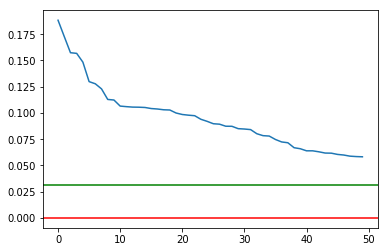

交易次數 vs rank


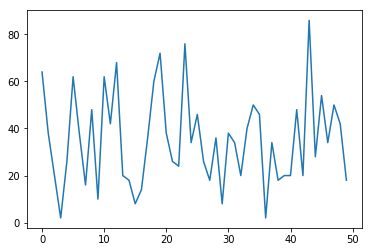

In [8]:
print("訓練集：")
print("報酬率 vs rank")
plt.figure(1) 
plt.plot(sortPerformance50) # X:第n個EPISODE Y:第n個EPISODE的績效(performance)
plt.axhline(y = 0, color='r', linestyle='-') # 加上0%報酬率的線(紅線)
plt.axhline(y = training_set_buy_and_hold_return, color='g', linestyle='-') # 加上B&H報酬率的線(綠線)
plt.show()

print("交易次數 vs rank")
plt.figure(2)
plt.plot(sortTradetimes) # X:第n個EPISODE Y:第n個EPISODE的total reward
plt.show()

In [9]:
    print("訓練集最後100個episode的平均報酬率為：" + str(np.mean(performance_list[EPISODES - 100 + 1 : EPISODES + 1])))

訓練集最後100個episode的平均報酬率為：-0.04418042852897583


報酬率 vs episode


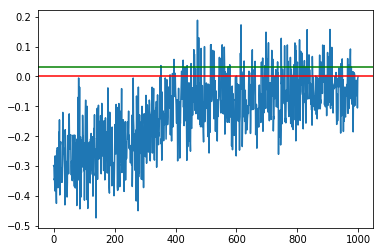

reward vs episode


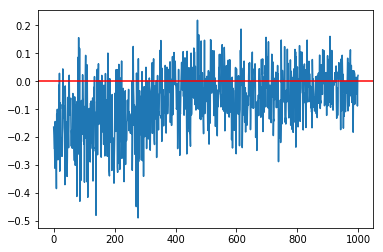

交易次數 vs episode


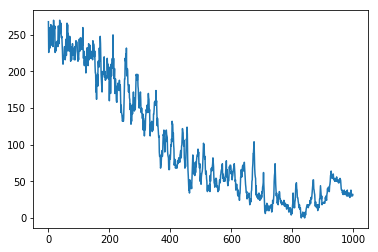

loss vs episode


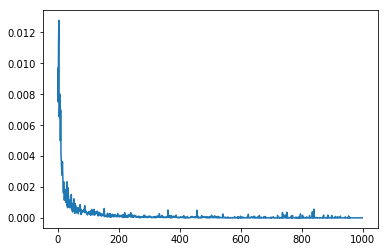

交易次數 vs 報酬率


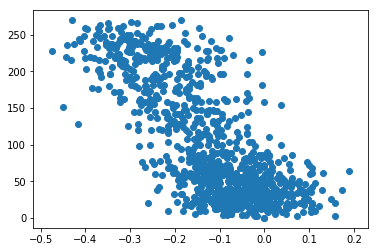

獎勵 vs 報酬率


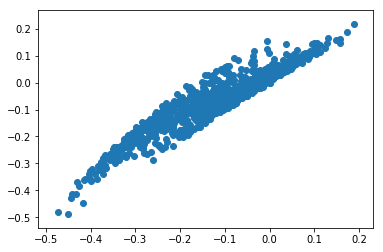

2.3707500185807363e-05


In [10]:
    #episode_index = range(1, EPISODES + 1)
    print("報酬率 vs episode")
    plt.figure(1) 
    plt.plot(performance_list) # X:第n個EPISODE Y:第n個EPISODE的績效(performance)
    plt.axhline(y = 0, color='r', linestyle='-') # 加上0%報酬率的線(紅線)
    plt.axhline(y = training_set_buy_and_hold_return, color='g', linestyle='-') # 加上B&H報酬率的線(綠線)
    plt.show()
    print("reward vs episode")
    plt.figure(2)
    plt.plot(reward_list) # X:第n個EPISODE Y:交易次數(第n個EPISODE一共發生close(selling stocks)的次數)
    plt.axhline(y = 0, color='r', linestyle='-') # 加上總獎勵為0的線(紅線)
    plt.show()
    print("交易次數 vs episode")
    plt.figure(3)
    plt.plot(transaction_times_list) # X:第n個EPISODE Y:第n個EPISODE的total reward
    plt.show()
    print("loss vs episode")
    plt.figure(4)
    plt.plot(loss_list) # Y:每一次訓練的loss值
    plt.show()
#     print("loss vs 後半段episode")
#     plt.figure(5)
#     plt.plot(loss_list[(EPISODES//2):EPISODES]) # Y:訓練後期每一次訓練的loss值
#     plt.show()
    print("交易次數 vs 報酬率")
    plt.figure(6)
    plt.scatter(performance_list, transaction_times_list) # Y:訓練後期每一次訓練的loss值
    plt.show()
    print("獎勵 vs 報酬率")
    plt.figure(7)
    plt.scatter(performance_list, reward_list) # Y:訓練後期每一次訓練的loss值
    plt.show()
    loss_list_new = [item.tolist() for item in loss_list[(EPISODES//2):]]
    print(np.mean(loss_list_new))
#     print(loss_list[(EPISODES//2):EPISODES])
    

In [11]:
print(len(performance_list))
print(len(reward_list))

1000
1000


In [12]:
    # 把param_dict中存的神經網路參數，按照實體報酬率的大小排序，並取排在前50名(暫定)的神經網路參數作為驗證時所用
#     top_param_num = 50 # 要取實體報酬率前幾名的神經網路參數
#     param_list = [] # 建立一個儲存神經網路參數的列表，之後用於驗證時用
    
#     for i in sorted(param_dict.items(), key=lambda d: d[0],reverse=True):
#         param_list.append(i[1])
#     param_list = param_list[:top_param_num]



    param_list50 = []

#     for idx, i in enumerate(sorted(performance_list, reverse=True)[:50]):

#         param_list50.append(param_list[idx])



    for p in sortPerformance50:
        trade_idx = sort_dict.get(p)
        print(trade_idx)
        param_list50.append(param_list[trade_idx])
    
        

472
615
907
832
697
476
747
807
705
792
517
553
515
767
883
794
888
758
516
495
560
698
913
484
974
460
652
716
522
796
527
811
899
815
613
462
838
873
849
904
777
544
902
474
686
550
965
947
703
719


## 存訓練集中表現較好的參數，作為下次訓練的起點

In [13]:
# # 排序後的第一個就是報酬率最高的，再從sort_dict取出他的index
# best_param_index_train = sort_dict.get(sortPerformance50[0]) 
# print(best_param_index)

# 儲存訓練集中最好的1組參數，因為是排序過的，第0個就是最好的
torch.save(param_list50[0], 'train_last_best_param_as_start.pkl')

In [14]:
# 儲存最好的50組參數
torch.save(param_list50, 'params_top50Return_Linear.pkl')
# param_list50 = torch.load('params_top50Return_Linear.pkl')


In [33]:
    # --------------- 驗證模型 ----------------
    # 取得驗證集
    csvfile_rows_validation_start_day = VALIDATION_START_DAY
    csvfile_rows_validation_start_day_index = -1
    
    csvfile_rows_validation_end_day = VALIDATION_END_DAY
    csvfile_rows_validation_end_day_index = -1
    
    for i in range(0, len(csvfile_rows)):
        if csvfile_rows[i][0] == csvfile_rows_validation_start_day:
            csvfile_rows_validation_start_day_index = i
        if csvfile_rows[i][0] == csvfile_rows_validation_end_day:
            csvfile_rows_validation_end_day_index = i
    
    csvfile_rows_validation = csvfile_rows[csvfile_rows_validation_start_day_index : csvfile_rows_validation_end_day_index + 1]

    # 對驗證集中連續型態的狀態變數資料做特徵縮放(feature scaling)
    csvfile_rows_validation = np.transpose(csvfile_rows_validation)
    csvfile_rows_validation = np.ndarray.tolist(csvfile_rows_validation)
    for i in csvfile_rows_validation[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1]:
        for j in range(0, len(i)):
            i[j] = float(i[j])
    
#     # 錯誤的方法
#     for i in csvfile_rows_validation[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1]:
#         status_variable_mean = statistics.mean(i)
#         status_variable_stdev = statistics.stdev(i)
#         for j in range(0, len(i)):
#             i[j] = (i[j] - status_variable_mean) / status_variable_stdev


#     for i in csvfile_rows_validation[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1]:
# #         status_variable_mean = statistics.mean(i)
# #         status_variable_stdev = statistics.stdev(i)
#         for k in range(len(train_mean_list)):
#             mean=train_mean_list[k]
#             std=train_std_list[k]
#             for j in range(0, len(i)):
#                 i[j] = (i[j] - mean) / std
            
     # 錯誤的正確方法1       
    for index,i in enumerate(csvfile_rows_validation[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1]):
#         status_variable_mean = statistics.mean(i)
#         status_variable_stdev = statistics.stdev(i)
#         train_mean_list = []
#     train_std_list = []
        for j in range(0, len(i)):
            i[j] = (i[j] - train_mean_list[index]) / train_std_list[index]
    
    # 錯誤的正確方法2
#     for i in range(len(csvfile_rows_validation[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1])):
# #         status_variable_mean = statistics.mean(i)
# #         status_variable_stdev = statistics.stdev(i)
# #         train_mean_list = []
# #     train_std_list = []
#         for j in range(0, len(csvfile_rows_validation[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1][i])):
#             csvfile_rows_validation[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1][i][j] = (csvfile_rows_validation[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1][1][j] - train_mean_list[i]) / train_std_list[i]
    
    csvfile_rows_validation = np.transpose(csvfile_rows_validation)
    csvfile_rows_validation = np.ndarray.tolist(csvfile_rows_validation)
    for i in csvfile_rows_validation:
        for j in range(1, N_COLUMNS):
            if i[j] != '' and j in [1,2,3] or j in range(STATE_VARIABLE_DISCRETE_START_INDEX, N_COLUMNS):
                i[j] = int(i[j])
            elif i[j] != '':
                i[j] = float(i[j])
    
    csvfile.close()
    
    '''
    驗證集的敘述統計
    '''
    csvfile_df = pd.read_csv("D:/專案/資料集/twse0050_ver10.csv")
    valid_df = pd.DataFrame(csvfile_rows_validation[STATE_VARIABLE_START_INDEX : 
                                                    STATE_VARIABLE_CONTINUOUS_END_INDEX + 1], columns = csvfile_df.columns)
    print("驗證集的敘述統計：")
    print(valid_df.describe())
    '''
    驗證集的敘述統計
    '''
    
    #print(csvfile_rows_validation[0:5])
    
    # 建立紀錄performance和transaction times的列表(list),之後畫圖會用到
    val_performance_list = []
    val_transaction_times_list = []
    
    episode_start_day_index = 1 # 挑選驗證集第二個交易日為episode開始的日期(因為會用到第一個交易日的狀態變數資料，所以要從第二天開始)
    episode_start_day = csvfile_rows_validation[episode_start_day_index][0]

    episode_end_day_index = len(csvfile_rows_validation) - 1 # 挑選驗證集倒數第一個交易日為episode結束的日期
    episode_end_day = csvfile_rows_validation[episode_end_day_index][0]
    
    validation_set_buy_and_hold_return = ((csvfile_rows_validation[len(csvfile_rows_validation) - 1][OPENING_PRICE_INDEX]
               - csvfile_rows_validation[0][OPENING_PRICE_INDEX]) / csvfile_rows_validation[0][OPENING_PRICE_INDEX])
    print("在驗證集中，使用B&H的報酬率為：", validation_set_buy_and_hold_return)
    
    # 儲存測試集所需要的agents
    test_agents = {}
    
    # 驗證時agent隨機選取行動的機率為0(agent完全照現在的參數選取動作)
    dqn.epsilon = 0
    net1 = Net()
    
    force_sell_counter = 0 # 強制賣掉的參數組數
    
    # ...
    for i_episode in range(len(param_list50)):
        
        print("第{}組參數/共{}組參數".format(str(i_episode + 1), str(len(param_list50))))

        # 把之前紀錄的神經網路參數複製到神經網路中，以驗證在這個參數下agent在股市交易的表現
        dqn.copy_params(param_list50[i_episode])
        net1.load_state_dict(param_list50[i_episode])

        # 重新一個episode時把所有驗證集中的資產持有狀態全部設為0 (開始投資之前不會有資料的資產持有狀態為1，因為根本還沒有開始買股票)
        for i in csvfile_rows_validation:
            i[CURRENT_POSITION_INDEX] = 0

        state = csvfile_rows_validation[episode_start_day_index - 1][STATE_VARIABLE_START_INDEX:] # 根據日期取得狀態變數
        np.asarray(state, dtype = float)
        state = np.reshape(state, [1, N_STATES]) # 為了讓狀態可以餵進神經網路所做的維度調整

        initial_principal = 100000 # 本金
        cash_hold = initial_principal # agent目前「實際」持有的現金
        transaction_cost_rate = 0.001425 # 交易成本(手續費)比率
        number_of_shares_held = 0 # 持有股數(每一次EPISODE開始前都要歸零)

        done = False # 是否結束該EPISODE(結束條件為在持有股票的狀態下選擇賣掉股票的行動)
        performance = 0 # 該EPISODE「實際」的投資報酬率
        transaction_times = 0 # 該EPISODE發生的交易次數(買和賣皆算進行一次交易)
        
        buy_price = 0 # 買入股票的價格
        
        profit = 0 # 賺到的錢，不再拿去投資

        for day in range(episode_start_day_index, episode_end_day_index + 1):

            # 選擇行動
            action = net1.choose_action(state)

            # 當EPISODE進行到倒數第一天時就要強制結束該EPISODE，因為後面沒資料了
            if day == (episode_end_day_index):
                done = True
                if (csvfile_rows_validation[day - 1][CURRENT_POSITION_INDEX] == 0): 
                    # 如果t-1期的agent之前持有的是現金，則繼續持有現金(wait)
                    action = 0
                    
                else:
                    # 如果agent之前持有的是股票，則強制賣出股票(sell)
                    action = 1 
                    
                    # 根據公式計算出agent在賣出股票後將會持有的現金
                    cash_hold = (number_of_shares_held * csvfile_rows_validation[day][CLOSING_PRICE_INDEX] 
                                 * (1 - transaction_cost_rate))

                    # 每賣出一次股票，該EPISODE的交易次數就增加一次
                    transaction_times += 1 
                    number_of_shares_held = 0
                    print("                     第{}組參數有在最後一天強制賣掉".format(i_episode + 1))
                    force_sell_counter += 1

            # 根據行動計算獎勵
            if csvfile_rows_validation[day - 1][CURRENT_POSITION_INDEX] == 0 and done == False:

                if action == 1: # 如果t-1期的當前資產部位為持有現金(current position = 0)，且行動為1(action = 1)，則買入股票(buy)
                    
                    # 買入股票的價格為t期的開盤價
                    buy_price = csvfile_rows_validation[day][CLOSING_PRICE_INDEX] 
                    
                    # 根據公式計算出agent在買入股票後將會持有的股數
                    number_of_shares_held = cash_hold  / (buy_price * (1 + transaction_cost_rate)) 
                    
                    # 買入股票後，t期的「資產當前部位」將設為1
                    csvfile_rows_validation[day][CURRENT_POSITION_INDEX] = 1
                    
                    # 由於將所有的現金拿去買股票，所以之後agent持有的現金為0
                    cash_hold = 0 
                    
                    # 每買入一次股票，該EPISODE的交易次數就增加一次
                    transaction_times += 1
                    print("買")

            elif csvfile_rows_validation[day - 1][CURRENT_POSITION_INDEX] == 1 and done == False:

                if action == 1: # 如果t-1期的當前資產部位為持有股票(current position = 1)，且行動為1(action = 1)，則賣出股票(sell)
   
                    # 根據公式計算出agent在賣出股票後將會持有的現金
                    cash_hold = (number_of_shares_held * csvfile_rows_validation[day][CLOSING_PRICE_INDEX] 
                                 * (1 - transaction_cost_rate))
                    
                    # 每賣出一次股票，該EPISODE的交易次數就增加一次
                    transaction_times += 1 
                    number_of_shares_held = 0
                    
                    # 若賺的錢超過本金，只拿本金再投資
#                     if cash_hold > initial_principal:
#                         profit += cash_hold - initial_principal
#                         cash_hold = initial_principal
                    print("賣")

                elif action == 0: # 如果當前資產部位為持有股票(current position = 1)，且行動為0(action = 0)，則繼續持有股票(hold)
                    
                    # 由於繼續持有股票，t期的「資產當前部位」將設為1
                    csvfile_rows_validation[day][CURRENT_POSITION_INDEX] = 1
                    print("持有")
            
            # 取得下一個狀態
            next_state = csvfile_rows_validation[day][STATE_VARIABLE_START_INDEX:]

            # 為了讓下一個狀態可以餵進神經網路所做的維度調整
            next_state = np.reshape(next_state, [1, N_STATES]) 
            
            # 更新狀態和股票持有的狀態
            state = next_state         
            
            # 每個episode結束時的處理事項
            if done: 
                # 計算實體報酬率
                performance = (cash_hold - initial_principal + profit) / initial_principal
                
                # 紀錄該episode的相關資訊                
                val_performance_list.append(performance)
                val_transaction_times_list.append(transaction_times)
                loss_list.append(dqn.loss)
                
                # 印出該episode的相關資訊
                print("該episode開始的日期為:", episode_start_day)
                print("該episode結束的日期為:", episode_end_day)
                print('該episode最後持有的現金為：', cash_hold + profit)
                print('該episode的實際報酬率(績效)為：', performance)
                print('該episode的交易次數為(買入和賣出股票的次數)：', transaction_times)
                print("該episode已賺得利潤為：", profit)
                print() # 空一行做為分隔
                
                # 將每個模型與實際報酬率都先儲存起來之後測試集要用
                test_agents[performance] = param_list50[i_episode]
print("被強制賣掉的參數組數為", force_sell_counter)

驗證集的敘述統計：
               成交股數          成交金額         成交筆數        開盤價        最高價  \
count  2.400000e+01  2.400000e+01    24.000000  24.000000  24.000000   
mean   1.203233e+07  7.042726e+08  3748.291667  58.558333  59.029167   
std    5.049799e+06  2.918665e+08  1577.110938   1.764916   1.757092   
min    4.584277e+06  2.721352e+08  1464.000000  55.900000  56.300000   
25%    7.916787e+06  4.693365e+08  2606.250000  57.000000  57.412500   
50%    1.148342e+07  7.007362e+08  3538.500000  58.650000  59.175000   
75%    1.469113e+07  8.477530e+08  4491.250000  60.450000  60.637500   
max    2.268837e+07  1.270702e+09  7993.000000  61.000000  61.600000   

             最低價        收盤價       漲跌價差     收盤價MA5    收盤價MA10  ...     4     5  \
count  24.000000  24.000000  24.000000  24.000000  24.000000  ...  24.0  24.0   
mean   58.204167  58.710417   0.183333  -1.736203  -1.823022  ...   0.0   0.0   
std     1.824049   1.745303   0.637193   0.418448   0.338879  ...   0.0   0.0   
min    55.600000 

[[[[-0.00046137 -0.02703016]]]]
[[[[-0.00090364 -0.03328557]]]]
[[[[-0.00088169 -0.03297502]]]]
[[[[-0.00093944 -0.03379181]]]]
[[[[-0.00123769 -0.0380102 ]]]]
[[[[-0.00128349 -0.03865809]]]]
[[[[-0.00117651 -0.03712241]]]]
[[[[-0.00241072 -0.05457906]]]]
[[[[-0.00313744 -0.06964689]]]]
[[[[-0.00286928 -0.06703869]]]]
[[[[-0.00289911 -0.06928419]]]]
[[[[-0.00285536 -0.06673386]]]]
[[[[-0.00279856 -0.06345992]]]]
[[[[-0.00230399 -0.06030728]]]]
[[[[-0.00218725 -0.06003537]]]]
[[[[-0.002165   -0.06194001]]]]
[[[[-0.00180523 -0.06054597]]]]
[[[[-0.00223016 -0.06762914]]]]
[[[[-0.00249614 -0.06892176]]]]
[[[[-0.0021187 -0.0680941]]]]
[[[[-0.00147249 -0.05473264]]]]
[[[[-0.00095813 -0.04719115]]]]
[[[[-0.00014541 -0.03693532]]]]
[[[[ 0.00051956 -0.02719612]]]]
[[[[ 0.00150808 -0.01184782]]]]
[[[[ 0.00198613 -0.0044601 ]]]]
[[[[ 0.00189268 -0.00593332]]]]
[[[[ 0.00195945 -0.00906798]]]]
該episode開始的日期為: 2016/1/5
該episode結束的日期為: 2016/3/31
該episode最後持有的現金為： 100000
該episode的實際報酬率(績效)為： 0.0
該epis

[[[[-0.00120142 -0.03100307]]]]
[[[[-0.00139508 -0.03363229]]]]
[[[[-0.00147984 -0.03478298]]]]
[[[[-0.00127917 -0.03205849]]]]
[[[[-0.00239218 -0.04644667]]]]
[[[[-0.0028754  -0.05567522]]]]
[[[[-0.0026004  -0.05263756]]]]
[[[[-0.00257697 -0.05342374]]]]
[[[[-0.0025936  -0.05238768]]]]
[[[[-0.00260746 -0.05112032]]]]
[[[[-0.00201755 -0.04595008]]]]
[[[[-0.0018469 -0.0446297]]]]
[[[[-0.00168795 -0.04388122]]]]
[[[[-0.00145146 -0.04288477]]]]
[[[[-0.00138994 -0.04243489]]]]
[[[[-0.00163285 -0.04465415]]]]
[[[[-0.00120214 -0.04114836]]]]
[[[[-0.00077577 -0.03353826]]]]
[[[[-0.00030953 -0.02727922]]]]
[[[[ 0.00046559 -0.0183636 ]]]]
[[[[ 0.00106324 -0.01076082]]]]
[[[[0.00185387 0.00021789]]]]
[[[[0.00236913 0.00714944]]]]
買
[[[[ 0.00143707 -0.00294732]]]]
持有
[[[[0.00225073 0.0044115 ]]]]
                     第8組參數有在最後一天強制賣掉
該episode開始的日期為: 2016/1/5
該episode結束的日期為: 2016/3/31
該episode最後持有的現金為： 101282.02621554937
該episode的實際報酬率(績效)為： 0.012820262155493692
該episode的交易次數為(買入和賣出股票的次數)： 2
該episo

[[[[ 0.00166548 -0.0151849 ]]]]
[[[[ 0.00158576 -0.01441962]]]]
[[[[ 0.0021659  -0.00920256]]]]
[[[[ 0.00318127 -0.00078777]]]]
[[[[ 0.00318054 -0.00270969]]]]
[[[[ 0.00263479 -0.00619547]]]]
[[[[ 0.00277123 -0.00481956]]]]
[[[[0.00551256 0.01652028]]]]
買
[[[[0.00392636 0.00682832]]]]
賣
[[[[0.00413713 0.00745012]]]]
買
[[[[0.00419586 0.00785105]]]]
賣
[[[[0.00383239 0.00588079]]]]
買
[[[[0.00360596 0.00359759]]]]
持有
[[[[0.00352018 0.00257677]]]]
持有
[[[[0.00360706 0.00072912]]]]
持有
[[[[ 0.00298095 -0.003755  ]]]]
持有
[[[[0.0032605 0.000114 ]]]]
持有
[[[[0.00348039 0.00233129]]]]
持有
[[[[0.00370663 0.00461268]]]]
賣
[[[[0.00380078 0.00507963]]]]
買
[[[[0.00416271 0.00669093]]]]
賣
[[[[ 0.00301042 -0.00240767]]]]
[[[[ 0.00314882 -0.00324235]]]]
[[[[ 0.00222109 -0.01036701]]]]
[[[[ 0.00148784 -0.01776092]]]]
[[[[ 0.0014713  -0.01792771]]]]
[[[[ 0.00126826 -0.01997506]]]]
[[[[ 0.00100195 -0.02266051]]]]
[[[[ 0.0007852  -0.02484616]]]]
[[[[ 0.00095657 -0.02311814]]]]
[[[[-0.00011191 -0.03356614]]]]
[[

[[[[-0.00125509 -0.04329005]]]]
[[[[-0.00253881 -0.06398419]]]]
[[[[-0.00338461 -0.08182831]]]]
[[[[-0.00309642 -0.07783427]]]]
[[[[-0.00311822 -0.07977124]]]]
[[[[-0.00307107 -0.07731701]]]]
[[[[-0.00300008 -0.07418566]]]]
[[[[-0.00261826 -0.07108663]]]]
[[[[-0.00260023 -0.07190728]]]]
[[[[-0.00266736 -0.07467371]]]]
[[[[-0.00230204 -0.0662341 ]]]]
[[[[-0.00303333 -0.08377875]]]]
[[[[-0.00337752 -0.08717737]]]]
[[[[-0.00295465 -0.08401012]]]]
[[[[-0.00236454 -0.07012128]]]]
[[[[-0.00189102 -0.06186835]]]]
[[[[-0.00123523 -0.0509912 ]]]]
[[[[-0.00069469 -0.04183798]]]]
[[[[ 0.00011663 -0.02388482]]]]
[[[[ 0.00052053 -0.01884662]]]]
[[[[ 0.00047941 -0.01715451]]]]
[[[[ 6.5679662e-05 -3.0063327e-02]]]]
該episode開始的日期為: 2016/1/5
該episode結束的日期為: 2016/3/31
該episode最後持有的現金為： 100000
該episode的實際報酬率(績效)為： 0.0
該episode的交易次數為(買入和賣出股票的次數)： 0
該episode已賺得利潤為： 0

第18組參數/共50組參數
[[[[-0.00097334 -0.03358303]]]]
[[[[-0.00076072 -0.02603555]]]]
[[[[-0.00083787 -0.02371835]]]]
[[[[-0.0010647  -0.02239484]]]

[[[[-0.00131273 -0.02761903]]]]
[[[[-0.00069973 -0.02077441]]]]
[[[[-0.0008653  -0.02230649]]]]
[[[[ 4.0561426e-05 -1.4253452e-02]]]]
[[[[ 0.00079697 -0.00685377]]]]
[[[[ 0.0002445  -0.01325072]]]]
[[[[ 0.00057262 -0.01033896]]]]
[[[[ 0.00065125 -0.00942457]]]]
[[[[0.0022091  0.00612667]]]]
買
[[[[0.00148215 0.00023729]]]]
持有
[[[[ 0.00127926 -0.00223486]]]]
持有
[[[[ 0.00131281 -0.00254772]]]]
持有
[[[[0.00148394 0.00025806]]]]
持有
[[[[ 0.00104559 -0.00483909]]]]
持有
[[[[ 0.00092549 -0.00623574]]]]
持有
[[[[ 0.00072418 -0.01026727]]]]
持有
[[[[ 0.00034491 -0.01341835]]]]
持有
[[[[ 0.00081943 -0.00746894]]]]
持有
[[[[ 0.00098616 -0.00553017]]]]
持有
[[[[ 0.00124959 -0.00246698]]]]
持有
[[[[ 0.00129204 -0.00197333]]]]
持有
[[[[ 0.00139988 -0.00230829]]]]
持有
[[[[ 0.00093495 -0.00612569]]]]
持有
[[[[ 0.00058724 -0.01097994]]]]
持有
[[[[ 0.00029197 -0.01360237]]]]
持有
[[[[-0.00031764 -0.02069116]]]]
持有
[[[[-0.0004031 -0.0216848]]]]
持有
[[[[-0.00049431 -0.02274549]]]]
持有
[[[[-0.00076475 -0.02589024]]]]
持有
[[[[-0.00088

[[[[ 0.00152942 -0.00588614]]]]
[[[[ 0.00168037 -0.00431309]]]]
[[[[ 0.00195687 -0.00143161]]]]
[[[[ 0.00200449 -0.00082279]]]]
[[[[0.00186736 0.00114733]]]]
[[[[ 0.0015668  -0.00549662]]]]
[[[[ 0.00114874 -0.00750946]]]]
[[[[ 0.00085313 -0.01293391]]]]
[[[[ 0.00016365 -0.02011913]]]]
[[[[ 3.6768150e-05 -2.1441422e-02]]]]
[[[[-7.500872e-05 -2.260628e-02]]]]
[[[[-0.00033369 -0.02530202]]]]
[[[[-0.00047997 -0.02682653]]]]
[[[[-0.00025858 -0.02451929]]]]
[[[[-0.00137012 -0.03460157]]]]
[[[[-0.00206005 -0.04122362]]]]
[[[[-0.0018275  -0.03871633]]]]
[[[[-0.0018857  -0.03933978]]]]
[[[[-0.00189883 -0.03919498]]]]
[[[[-0.00195057 -0.03967879]]]]
[[[[-0.00123002 -0.03356112]]]]
[[[[-0.00104333 -0.03193159]]]]
[[[[-0.000913  -0.0306037]]]]
[[[[-0.00089258 -0.03061657]]]]
[[[[-0.00045887 -0.02521133]]]]
[[[[-0.0011703  -0.03105449]]]]
[[[[-0.00044527 -0.024947  ]]]]
[[[[-0.00038287 -0.02331631]]]]
[[[[ 0.00022954 -0.01749496]]]]
[[[[ 0.00098227 -0.00974718]]]]
[[[[ 0.00150911 -0.00338911]]]]
[[

[[[[ 0.00048463 -0.02544863]]]]
持有
[[[[ 0.00065442 -0.02365096]]]]
持有
[[[[-0.00060284 -0.03441966]]]]
持有
[[[[-0.00174648 -0.04576785]]]]
持有
[[[[-0.00141844 -0.04257679]]]]
持有
[[[[-0.00146631 -0.04352285]]]]
持有
[[[[-0.00134078 -0.04158066]]]]
持有
[[[[-0.0011834  -0.03972577]]]]
持有
[[[[-0.00154307 -0.0405452 ]]]]
持有
[[[[-0.00130307 -0.03857092]]]]
持有
[[[[-0.00124364 -0.03794954]]]]
持有
[[[[-0.00199081 -0.03881047]]]]
持有
[[[[-0.00064027 -0.03409228]]]]
持有
[[[[-0.00028174 -0.03299623]]]]
持有
[[[[-0.00013038 -0.03056409]]]]
持有
[[[[ 0.00059589 -0.02327529]]]]
持有
[[[[ 0.00088989 -0.01884897]]]]
持有
[[[[ 0.0016187  -0.00981697]]]]
持有
[[[[0.00280355 0.00010005]]]]
持有
[[[[0.0038234  0.01260944]]]]
賣
[[[[0.00661503 0.02972481]]]]
買
[[[[0.00429456 0.01781119]]]]
賣
[[[[0.00737655 0.03389976]]]]
該episode開始的日期為: 2016/1/5
該episode結束的日期為: 2016/3/31
該episode最後持有的現金為： 111310.34240161146
該episode的實際報酬率(績效)為： 0.11310342401611459
該episode的交易次數為(買入和賣出股票的次數)： 8
該episode已賺得利潤為： 0

第32組參數/共50組參數
[[[[-0.00085378 -0.

[[[[-0.00241707 -0.03462085]]]]
持有
[[[[-0.00227623 -0.03454768]]]]
持有
[[[[-0.00236865 -0.03413658]]]]
持有
[[[[-0.00222832 -0.03239893]]]]
持有
[[[[-0.00222881 -0.03094231]]]]
持有
[[[[-0.00270422 -0.032157  ]]]]
持有
[[[[-0.0016855  -0.02182445]]]]
持有
[[[[-0.00190064 -0.02543651]]]]
持有
[[[[-0.00152617 -0.01942215]]]]
持有
[[[[-0.00116219 -0.01874639]]]]
持有
[[[[-0.00077428 -0.01516454]]]]
持有
[[[[-0.00026964 -0.01049138]]]]
持有
[[[[ 0.00065951 -0.00266217]]]]
持有
[[[[0.00168543 0.00608443]]]]
賣
[[[[0.0037286  0.02374837]]]]
買
[[[[0.00233242 0.012321  ]]]]
賣
[[[[0.00424594 0.03114868]]]]
該episode開始的日期為: 2016/1/5
該episode結束的日期為: 2016/3/31
該episode最後持有的現金為： 111264.95893852068
該episode的實際報酬率(績效)為： 0.11264958938520678
該episode的交易次數為(買入和賣出股票的次數)： 16
該episode已賺得利潤為： 0

第36組參數/共50組參數
[[[[ 0.00415397 -0.02518898]]]]
[[[[ 0.00365532 -0.01687863]]]]
[[[[ 0.00278253 -0.01716194]]]]
[[[[ 0.00262651 -0.02244977]]]]
[[[[ 0.00175035 -0.02659088]]]]
[[[[ 0.00288573 -0.01940818]]]]
[[[[ 0.00280875 -0.01801354]]]]
[[

[[[[-0.00273652 -0.05254833]]]]
持有
[[[[-0.00277989 -0.0544435 ]]]]
持有
[[[[-0.00279792 -0.05305947]]]]
持有
[[[[-0.00283039 -0.05170198]]]]
持有
[[[[-0.00270569 -0.05373787]]]]
持有
[[[[-0.00262637 -0.05378509]]]]
持有
[[[[-0.00259715 -0.05483298]]]]
持有
[[[[-0.00238574 -0.05478393]]]]
持有
[[[[-0.00217474 -0.05152538]]]]
持有
[[[[-0.00254355 -0.05374738]]]]
持有
[[[[-0.0021202  -0.05196106]]]]
持有
[[[[-0.00202837 -0.04727464]]]]
持有
[[[[-0.00168827 -0.04283487]]]]
持有
[[[[-0.00101667 -0.03688752]]]]
持有
[[[[-0.00029494 -0.02958954]]]]
持有
[[[[ 0.00053678 -0.01886474]]]]
持有
[[[[ 0.00119205 -0.01128594]]]]
持有
[[[[ 0.00088545 -0.01205358]]]]
持有
[[[[ 0.0019313  -0.00634816]]]]
                     第41組參數有在最後一天強制賣掉
該episode開始的日期為: 2016/1/5
該episode結束的日期為: 2016/3/31
該episode最後持有的現金為： 115530.4833085971
該episode的實際報酬率(績效)為： 0.15530483308597104
該episode的交易次數為(買入和賣出股票的次數)： 2
該episode已賺得利潤為： 0

第42組參數/共50組參數
[[[[ 0.00175799 -0.02704164]]]]
[[[[ 0.00154862 -0.01790241]]]]
[[[[ 0.00110016 -0.01640478]]]]
[[[[ 0.001288

[[[[ 0.00024033 -0.01427677]]]]
[[[[ 0.00011237 -0.02178923]]]]
[[[[ 5.7799509e-05 -1.8806987e-02]]]]
[[[[-0.00030249 -0.02995707]]]]
[[[[-0.00031328 -0.02801704]]]]
[[[[-0.00054024 -0.03365007]]]]
[[[[-0.00042981 -0.03090936]]]]
[[[[-0.00039483 -0.03004099]]]]
[[[[-0.00073444 -0.03847018]]]]
[[[[-0.00072497 -0.03823506]]]]
[[[[-0.00083996 -0.03978093]]]]
[[[[-0.00195669 -0.05426674]]]]
[[[[-0.00283557 -0.06567936]]]]
[[[[-0.00273929 -0.06174788]]]]
[[[[-0.00287131 -0.06273159]]]]
[[[[-0.00278634 -0.06136874]]]]
[[[[-0.00263409 -0.0602973 ]]]]
[[[[-0.00233917 -0.05649878]]]]
[[[[-0.00237806 -0.05693945]]]]
[[[[-0.00257111 -0.05832726]]]]
[[[[-0.00247509 -0.05144309]]]]
[[[[-0.00309529 -0.06062311]]]]
[[[[-0.00338008 -0.06591542]]]]
[[[[-0.003235   -0.06050958]]]]
[[[[-0.00264325 -0.05291179]]]]
[[[[-0.00219018 -0.04615479]]]]
[[[[-0.00171578 -0.03971371]]]]
[[[[-0.00112351 -0.03286187]]]]
[[[[-0.00022133 -0.0195101 ]]]]
[[[[ 0.00017994 -0.0146164 ]]]]
[[[[ 9.8290620e-05 -1.2311302e-02]

In [16]:
    print("驗證集的平均報酬率為：" + str(np.mean(val_performance_list)))
    print("驗證集的平均交易次數為：" + str(np.mean(val_transaction_times_list)))

驗證集的平均報酬率為：0.03871160282854902
驗證集的平均交易次數為：4.32


In [17]:
# # 驗證集排名前50 畫 報酬率 VS rank、交易次數 VS rank
# # 用字典存報酬率和idx
# sort_dict_valid = {}
# for idx, p in enumerate(val_performance_list):
#     sort_dict_valid[p] = idx
# # print(sortPerformance)
# sortPerformance = sorted(val_performance_list, reverse = True)
# sortPerformance50 = sortPerformance[:50]
# # len(sortPerformance50)

# # 交易次數是報酬率前50的交易次數
# # 再從以排序的報酬率列表中，用報酬率為key，抓原始報酬率列表的index(第幾個episode)
# # 再用這個index丟正確的交易次數進去sortTradetimes
# sortTradetimes = []
# for p in sortPerformance50:
#     trade_idx = sort_dict_valid.get(p)
#     sortTradetimes.append(val_transaction_times_list[trade_idx])
    
# print(sortTradetimes)
    

驗證集：
報酬率 vs rank


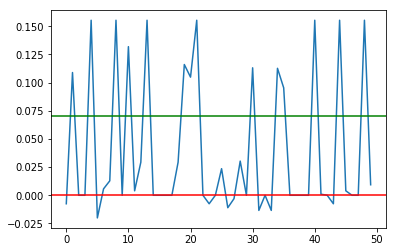

交易次數 vs rank


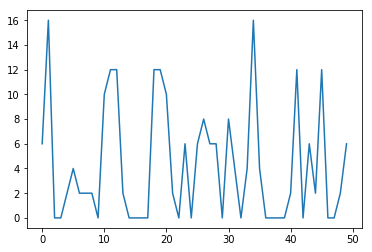

In [18]:
print("驗證集：")
print("報酬率 vs rank")
plt.figure(1) 
plt.plot(val_performance_list) # X:第n個EPISODE Y:第n個EPISODE的績效(performance)
plt.axhline(y = 0, color='r', linestyle='-') # 加上0%報酬率的線(紅線)
plt.axhline(y = validation_set_buy_and_hold_return, color='g', linestyle='-') # 加上B&H報酬率的線(綠線)
plt.show()

print("交易次數 vs rank")
plt.figure(2)
plt.plot(val_transaction_times_list) # X:第n個EPISODE Y:第n個EPISODE的total reward
plt.show()

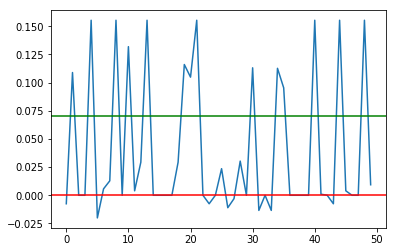

In [19]:
    plt.figure(5) 
    plt.plot(val_performance_list) # X:第n個EPISODE Y:第n個EPISODE的報酬率(performance)
    plt.axhline(y = 0, color='r', linestyle='-') # 加上0%報酬率的線(紅線)
    plt.axhline(y = validation_set_buy_and_hold_return, color='g', linestyle='-') # 加上B&H報酬率的線(綠線)

In [20]:
#取出最好的 n 個agent，每個各握有25000元 從2017/06/30到2017/12/29實際再去玩一次
test_param_list = [] # 儲存 n 個模型參數
Test_AGENTS_NUM = 50
for i in sorted(test_agents.items(), key=lambda d: d[0],reverse=True):
    test_param_list.append(i[1])
test_param_list = test_param_list[:Test_AGENTS_NUM]

In [21]:
    # --------------- 測試模型 ----------------
    # 取得測試集
    csvfile_rows_test_start_day = TEST_START_DAY
    csvfile_rows_test_start_day_index = -1
    
    csvfile_rows_test_end_day = TEST_END_DAY
    csvfile_rows_test_end_day_index = -1
    
    for i in range(0, len(csvfile_rows)):
        if csvfile_rows[i][0] == csvfile_rows_test_start_day:
            csvfile_rows_test_start_day_index = i
        if csvfile_rows[i][0] == csvfile_rows_test_end_day:
            csvfile_rows_test_end_day_index = i
    
    csvfile_rows_test = csvfile_rows[csvfile_rows_test_start_day_index : csvfile_rows_test_end_day_index + 1]

    # 對測試集中連續型態的狀態變數資料做特徵縮放(feature scaling)
    csvfile_rows_test = np.transpose(csvfile_rows_test)
    csvfile_rows_test = np.ndarray.tolist(csvfile_rows_test)
    for i in csvfile_rows_test[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1]:
        for j in range(0, len(i)):
            i[j] = float(i[j])
    
    for index, i in enumerate(csvfile_rows_test[STATE_VARIABLE_START_INDEX : STATE_VARIABLE_CONTINUOUS_END_INDEX + 1]):
        for j in range(0, len(i)):
            i[j] = (i[j] - train_mean_list[index]) / train_std_list[index]
    
    csvfile_rows_test = np.transpose(csvfile_rows_test)
    csvfile_rows_test = np.ndarray.tolist(csvfile_rows_test)
    for i in csvfile_rows_test:
        for j in range(1, N_COLUMNS):
            if i[j] != '' and j in [1,2,3] or j in range(STATE_VARIABLE_DISCRETE_START_INDEX, N_COLUMNS):
                i[j] = int(i[j])
            elif i[j] != '':
                i[j] = float(i[j])

    
    csvfile.close()
                
    #print(csvfile_rows_test[0:5])
    
    # 建立紀錄performance和transaction times的列表(list),之後畫圖會用到
    #performance_list = []
    #transaction_times_list = []
    
    #紀錄所有agent的報酬總和
    performance_total = 0
    
    episode_start_day_index = 1 # 挑選測試集第二個交易日為episode開始的日期(因為會用到第一個交易日的狀態變數資料，所以要從第二天開始)
    episode_start_day = csvfile_rows_test[episode_start_day_index][0]

    episode_end_day_index = len(csvfile_rows_test) - 1 # 挑選測試集倒數第一個交易日為episode結束的日期
    episode_end_day = csvfile_rows_test[episode_end_day_index][0]
    
    test_set_buy_and_hold_return = ((csvfile_rows_test[len(csvfile_rows_test) - 1][OPENING_PRICE_INDEX]
               - csvfile_rows_test[0][OPENING_PRICE_INDEX]) / csvfile_rows_test[0][OPENING_PRICE_INDEX])
    print("在測試集中，使用B&H的報酬率為：", test_set_buy_and_hold_return)
    
    # 測試時agent隨機選取行動的機率為0(agent完全照現在的參數選取動作)
    dqn.epsilon = 0
    
    performance_list_test = []
    transaction_times_list_test = []
    
    force_sell_counter = 0 # 強制賣掉的參數組數
    
    # ...
    for i_episode in range(len(param_list50)):
        
        print("第{}組參數/共{}組參數".format(str(i_episode + 1), str(len(param_list50))))

        # 把之前紀錄的神經網路參數複製到神經網路中，以測試在這個參數下agent在股市交易的表現
        dqn.copy_params(param_list50[i_episode])

        # 重新一個episode時把所有測試集中的資產持有狀態全部設為0 (開始投資之前不會有資料的資產持有狀態為1，因為根本還沒有開始買股票)
        for i in csvfile_rows_test:
            i[CURRENT_POSITION_INDEX] = 0

        state = csvfile_rows_test[episode_start_day_index - 1][STATE_VARIABLE_START_INDEX:] # 根據日期取得狀態變數
        np.asarray(state, dtype = float)
        state = np.reshape(state, [1, N_STATES]) # 為了讓狀態可以餵進神經網路所做的維度調整

        initial_principal = 100000/Test_AGENTS_NUM # 本金
        cash_hold = initial_principal # agent目前「實際」持有的現金
        transaction_cost_rate = 0.001425 # 交易成本(手續費)比率
        number_of_shares_held = 0 # 持有股數(每一次EPISODE開始前都要歸零)

        done = False # 是否結束該EPISODE(結束條件為在持有股票的狀態下選擇賣掉股票的行動)
        performance = 0 # 該EPISODE「實際」的投資報酬率
        transaction_times = 0 # 該EPISODE發生的交易次數(買和賣皆算進行一次交易)
        
        buy_price = 0 # 買入股票的價格
        
        profit = 0 # 賺到的錢，不再拿去投資

        for day in range(episode_start_day_index, episode_end_day_index + 1):

            # 選擇行動
            action = dqn.choose_action(state)

            # 當EPISODE進行到倒數第一天時就要強制結束該EPISODE，因為後面沒資料了
            if day == (episode_end_day_index):
                done = True
                if (csvfile_rows_test[day - 1][CURRENT_POSITION_INDEX] == 0): 
                    # 如果t-1期的agent之前持有的是現金，則繼續持有現金(wait)
                    action = 0
                    
                else:
                    # 如果agent之前持有的是股票，則強制賣出股票(sell)
                    action = 1 
                    
                    # 根據公式計算出agent在賣出股票後將會持有的現金
                    cash_hold = (number_of_shares_held * csvfile_rows_test[day][CLOSING_PRICE_INDEX] 
                                 * (1 - transaction_cost_rate))

                    # 每賣出一次股票，該EPISODE的交易次數就增加一次
                    transaction_times += 1 
                    number_of_shares_held = 0
                    print("                     第{}組參數有在最後一天強制賣掉".format(i_episode + 1))
                    force_sell_counter += 1

            # 根據行動計算獎勵
            if csvfile_rows_test[day - 1][CURRENT_POSITION_INDEX] == 0 and done == False:

                if action == 1: # 如果t-1期的當前資產部位為持有現金(current position = 0)，且行動為1(action = 1)，則買入股票(buy)
                    
                    # 買入股票的價格為t期的開盤價
                    buy_price = csvfile_rows_test[day][CLOSING_PRICE_INDEX] 
                    
                    # 根據公式計算出agent在買入股票後將會持有的股數
                    number_of_shares_held = cash_hold  / (buy_price * (1 + transaction_cost_rate)) 
                    
                    # 買入股票後，t期的「資產當前部位」將設為1
                    csvfile_rows_test[day][CURRENT_POSITION_INDEX] = 1
                    
                    # 由於將所有的現金拿去買股票，所以之後agent持有的現金為0
                    cash_hold = 0 
                    
                    # 每買入一次股票，該EPISODE的交易次數就增加一次
                    transaction_times += 1

            elif csvfile_rows_test[day - 1][CURRENT_POSITION_INDEX] == 1 and done == False:

                if action == 1: # 如果t-1期的當前資產部位為持有股票(current position = 1)，且行動為1(action = 1)，則賣出股票(sell)
   
                    # 根據公式計算出agent在賣出股票後將會持有的現金
                    cash_hold = (number_of_shares_held * csvfile_rows_test[day][CLOSING_PRICE_INDEX] 
                                 * (1 - transaction_cost_rate))
                    
                    # 每賣出一次股票，該EPISODE的交易次數就增加一次
                    transaction_times += 1 
                    number_of_shares_held = 0
                    
                    # 若賺的錢超過本金，只拿本金再投資
#                     if cash_hold > initial_principal:
#                         profit += cash_hold - initial_principal
#                         cash_hold = initial_principal

                elif action == 0: # 如果當前資產部位為持有股票(current position = 1)，且行動為0(action = 0)，則繼續持有股票(hold)
                    
                    # 由於繼續持有股票，t期的「資產當前部位」將設為1
                    csvfile_rows_test[day][CURRENT_POSITION_INDEX] = 1
            
            # 取得下一個狀態
            next_state = csvfile_rows_test[day][STATE_VARIABLE_START_INDEX:]

            # 為了讓下一個狀態可以餵進神經網路所做的維度調整
            next_state = np.reshape(next_state, [1, N_STATES]) 
            
            # 更新狀態和股票持有的狀態
            state = next_state         
            
            # 每個episode結束時的處理事項
            
            if done: 
                # 計算實體報酬率
                performance = (cash_hold - initial_principal + profit) / initial_principal
                
                # 紀錄該episode的相關資訊                
                performance_list_test.append(performance)
                transaction_times_list_test.append(transaction_times)
                loss_list.append(dqn.loss)
                performance_total += cash_hold
                
                # 印出該episode的相關資訊
                print("該episode開始的日期為:", episode_start_day)
                print("該episode結束的日期為:", episode_end_day)
                print('該episode最後持有的現金為：', cash_hold + profit)
                print('該episode的實際報酬率(績效)為：', performance)
                print('該episode的交易次數為(買入和賣出股票的次數)：', transaction_times)
                print("該episode已賺得利潤為：", profit)
                print() # 空一行做為分隔
print("被強制賣掉的參數組數為", force_sell_counter)

在測試集中，使用B&H的報酬率為： 0.014007782101167404
第1組參數/共50組參數
                     第1組參數有在最後一天強制賣掉
該episode開始的日期為: 2016/4/6
該episode結束的日期為: 2016/6/30
該episode最後持有的現金為： 1977.9503913182004
該episode的實際報酬率(績效)為： -0.011024804340899778
該episode的交易次數為(買入和賣出股票的次數)： 40
該episode已賺得利潤為： 0

第2組參數/共50組參數
該episode開始的日期為: 2016/4/6
該episode結束的日期為: 2016/6/30
該episode最後持有的現金為： 1921.2616826956994
該episode的實際報酬率(績效)為： -0.03936915865215031
該episode的交易次數為(買入和賣出股票的次數)： 46
該episode已賺得利潤為： 0

第3組參數/共50組參數
                     第3組參數有在最後一天強制賣掉
該episode開始的日期為: 2016/4/6
該episode結束的日期為: 2016/6/30
該episode最後持有的現金為： 2107.681827306586
該episode的實際報酬率(績效)為： 0.053840913653293
該episode的交易次數為(買入和賣出股票的次數)： 20
該episode已賺得利潤為： 0

第4組參數/共50組參數
該episode開始的日期為: 2016/4/6
該episode結束的日期為: 2016/6/30
該episode最後持有的現金為： 2016.8830279775916
該episode的實際報酬率(績效)為： 0.008441513988795805
該episode的交易次數為(買入和賣出股票的次數)： 32
該episode已賺得利潤為： 0

第5組參數/共50組參數
                     第5組參數有在最後一天強制賣掉
該episode開始的日期為: 2016/4/6
該episode結束的日期為: 2016/6/30
該episode最後持有的現金為：

                     第47組參數有在最後一天強制賣掉
該episode開始的日期為: 2016/4/6
該episode結束的日期為: 2016/6/30
該episode最後持有的現金為： 1972.813279346797
該episode的實際報酬率(績效)為： -0.013593360326601555
該episode的交易次數為(買入和賣出股票的次數)： 26
該episode已賺得利潤為： 0

第48組參數/共50組參數
該episode開始的日期為: 2016/4/6
該episode結束的日期為: 2016/6/30
該episode最後持有的現金為： 1973.5666290206777
該episode的實際報酬率(績效)為： -0.013216685489661132
該episode的交易次數為(買入和賣出股票的次數)： 28
該episode已賺得利潤為： 0

第49組參數/共50組參數
                     第49組參數有在最後一天強制賣掉
該episode開始的日期為: 2016/4/6
該episode結束的日期為: 2016/6/30
該episode最後持有的現金為： 1876.5553548521332
該episode的實際報酬率(績效)為： -0.06172232257393341
該episode的交易次數為(買入和賣出股票的次數)： 42
該episode已賺得利潤為： 0

第50組參數/共50組參數
                     第50組參數有在最後一天強制賣掉
該episode開始的日期為: 2016/4/6
該episode結束的日期為: 2016/6/30
該episode最後持有的現金為： 1876.5553548521332
該episode的實際報酬率(績效)為： -0.06172232257393341
該episode的交易次數為(買入和賣出股票的次數)： 42
該episode已賺得利潤為： 0

被強制賣掉的參數組數為 19


In [22]:
print('總金額為: %f' % performance_total)
preformance_ratio = ((performance_total - initial_principal*Test_AGENTS_NUM) / (initial_principal*Test_AGENTS_NUM))
print('實際報酬率(績效)為: %f' % preformance_ratio)

總金額為: 96808.965593
實際報酬率(績效)為: -0.031910


In [23]:
# # 測試集排名前50 畫 報酬率 VS rank、交易次數 VS rank
# # 用字典存報酬率和idx
# sort_dict_test = {}
# for idx, p in enumerate(performance_list_test):
#     sort_dict_test[p] = idx
# # print(sortPerformance)
# sortPerformance = sorted(performance_list_test, reverse = True)
# sortPerformance50 = sortPerformance[:50]
# # print(len(sortPerformance50))

# # 交易次數是報酬率前50的交易次數
# # 再從以排序的報酬率列表中，用報酬率為key，抓原始報酬率列表的index(第幾個episode)
# # 再用這個index丟正確的交易次數進去sortTradetimes
# sortTradetimes = []
# for p in sortPerformance50:
#     trade_idx = sort_dict_test.get(p)
#     sortTradetimes.append(transaction_times_list_test[trade_idx])
    
# print(sortTradetimes)
    

測試集：
報酬率 vs rank


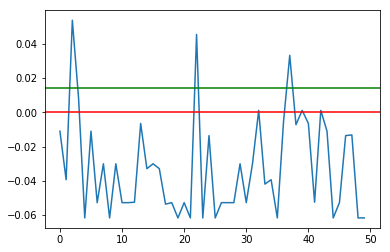

交易次數 vs rank


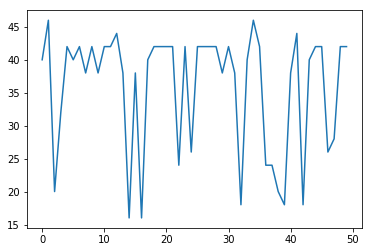

In [24]:
print("測試集：")
print("報酬率 vs rank")
plt.figure(1) 
plt.plot(performance_list_test) # X:第n個EPISODE Y:第n個EPISODE的績效(performance)
plt.axhline(y = 0, color='r', linestyle='-') # 加上0%報酬率的線(紅線)
plt.axhline(y = test_set_buy_and_hold_return, color='g', linestyle='-') # 加上B&H報酬率的線(綠線)
plt.show()

print("交易次數 vs rank")
plt.figure(2)
plt.plot(transaction_times_list_test) # X:第n個EPISODE Y:第n個EPISODE的total reward
plt.show()

## 存測試集中表現較好的參數，作為下次訓練的起點(暫不採用)

In [25]:
# a = np.array(performance_list_test)
# best_param_index = np.argmax(a)
# print(best_param_index)

# # 儲存最好的1組參數
# torch.save(param_list50[best_param_index], 'last_best_param_as_start.pkl')
# # print(param_list50[best_param_index])
# print(sortPerformance50[best_param_index])

## 畫出個股和台灣50的2014~2016收盤價趨勢圖

In [26]:
import matplotlib.ticker as ticker
x = pd.read_csv("D:\\專案\\資料集\\燦坤2430.csv", encoding='utf-8', index_col = '日期') # 路徑請自行修改

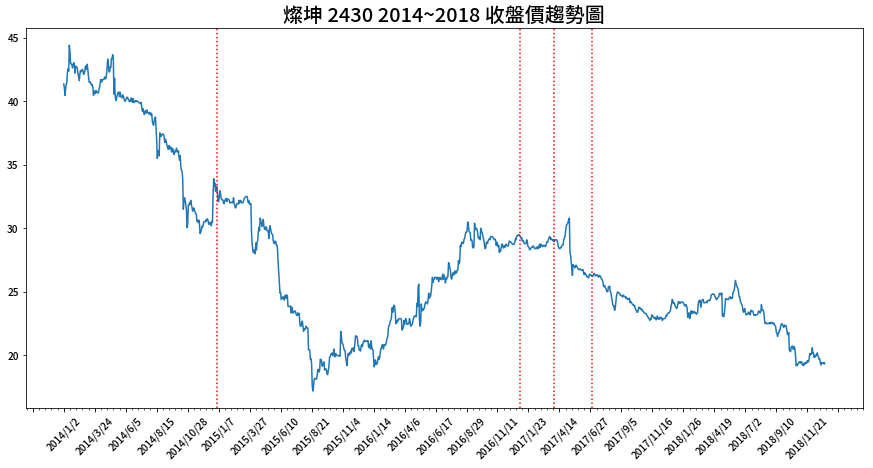

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(x.loc["2014/1/2":"2018/12/28","收盤價"])
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
plt.title("燦坤 2430 2014~2018 收盤價趨勢圖", fontsize=20)
xmajorLocator = ticker.MultipleLocator(50) # 每幾天顯示一次主要刻度
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = ticker.MultipleLocator(10) # 每幾天顯示一次次要刻度
ax.xaxis.set_minor_locator(xminorLocator)
plt.axvline(x = '2015/1/5', color='r', linestyle=':')
plt.axvline(x = '2017/1/3', color='r', linestyle=':')
plt.axvline(x = '2017/3/31', color='r', linestyle=':')
plt.axvline(x = '2017/6/30', color='r', linestyle=':')
plt.xticks(rotation = 45)
plt.show()
# [2617:3353]

In [28]:
y = pd.read_csv("D:\\專案\\資料集\\twse0050_ver10.csv", index_col = '日期') # 路徑請自行修改

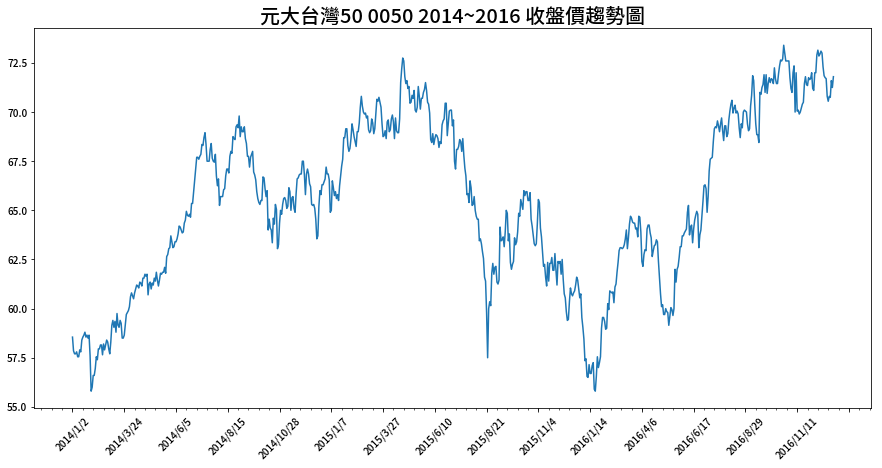

In [29]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(y.loc["2014/1/2":"2016/12/30","收盤價"])
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
plt.title("元大台灣50 0050 2014~2016 收盤價趨勢圖", fontsize=20)
xmajorLocator = ticker.MultipleLocator(50) # 每幾天顯示一次主要刻度
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = ticker.MultipleLocator(10) # 每幾天顯示一次次要刻度
ax.xaxis.set_minor_locator(xminorLocator)
plt.xticks(rotation = 45)
plt.show()
# [2617:3353]

In [30]:
z = pd.read_csv("D:\\專案\\資料集\\東元1504.csv", index_col = '日期') # 路徑請自行修改

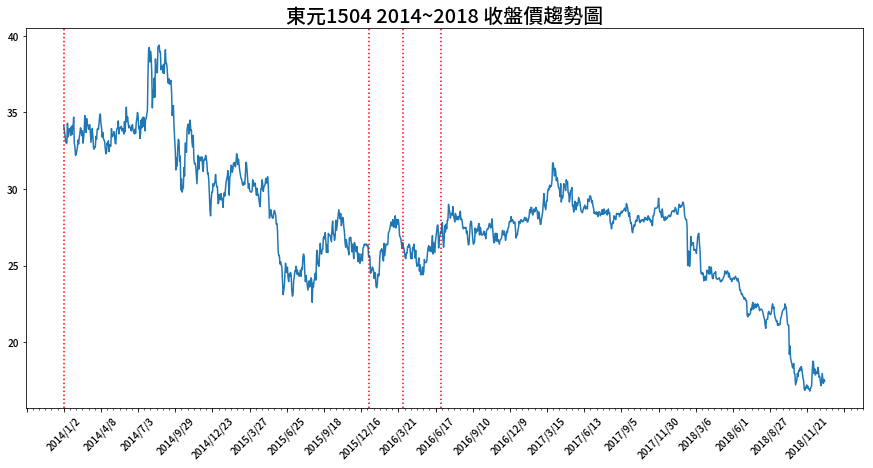

In [31]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(z.loc["2014/1/2":"2018/12/28","收盤價"])
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
plt.title("東元1504 2014~2018 收盤價趨勢圖", fontsize=20)
xmajorLocator = ticker.MultipleLocator(60) # 每幾天顯示一次主要刻度
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = ticker.MultipleLocator(10) # 每幾天顯示一次次要刻度
ax.xaxis.set_minor_locator(xminorLocator)
plt.axvline(x = '2014/1/2', color='r', linestyle=':')
plt.axvline(x = '2016/1/4', color='r', linestyle=':')
plt.axvline(x = '2016/3/31', color='r', linestyle=':')
plt.axvline(x = '2016/6/30', color='r', linestyle=':')
plt.xticks(rotation = 45)
plt.show()
# [2617:3353]